# Module 7. 邊緣檢測
## 7-1 : 什麼是邊緣檢測

> Edge detection 邊緣偵測是 Computer Vision 中最重要的步驟，它讓電腦能準確的抓取圖中的物體，這項技術運用到相當複雜的數學運算，以檢查影像中各像素點的顏色變化程度來區分邊界。有了邊緣之後，這些交錯的線段中會有所謂的`輪廓`，而這也是電腦取得影像中物件的依據。

> openCV 提供三種邊緣檢測方式來處理 `Sobel、Canny 及 Laplacian`，這些技術皆是使用 `灰階` 的影像，基於每個像素灰度的不同，利用不同物體在其邊界處會`有明顯的邊緣特徵來分辨`。這三種方法皆使用了`一維甚至於二維的微分`，嚴格來說，若依其使用技術原理的不同可分為兩種：

> * 而 Sobel 和 Canny 使用的則是 Gradient methods（梯度原理），它是透過計算像素光度的`一階導數差異`（detect changes in the first derivative of intensity）來進行邊緣檢測。
> * Laplacian 原稱為 Laplacian method，透過計算零交越點上光度的`二階導數`（detect zero crossings of the second derivative on intensity changes）

> ### 離散導數
><img src=".\image\sobel_dev.jpg"  style='height:250px; width:750px'></img>

## 7-2 : Sobel、Scharr、Laplacian

### 絕對值

In [1]:
import cv2
import numpy as np
img=np.random.randint(-256, 256, size=[4, 5], dtype=np.int16)   # –32768 ~ 32767,  0 ~ 65535
rst=cv2.convertScaleAbs(img)                                    # 絕對值
print(f'img =\n{img}\n\n'
      f'rst =\n{rst}\n\n'
      f'np.abs()\n{np.abs(img)}')    # numpy 也可以

img =
[[ -82  200  -95  186   28]
 [ 155  -87  225 -103  224]
 [-226  -98   44  144  -27]
 [ 181  241  -47   71 -194]]

rst =
[[ 82 200  95 186  28]
 [155  87 225 103 224]
 [226  98  44 144  27]
 [181 241  47  71 194]]

np.abs()
[[ 82 200  95 186  28]
 [155  87 225 103 224]
 [226  98  44 144  27]
 [181 241  47  71 194]]


### Sobel : 是一種過濾器，只是其是帶有`方向`的
> 結合了`高斯平滑與微分運算`的結合方法, 所以它的抗噪聲能力很強

> Sobel 與 Canny 兩者雖然使用`相同的底層技術`，但執行方式有些差異。Sobel 以簡單的卷積過濾器（convolutional filter）偵測圖像上`水平及縱向`光度的改變，以`加權平均方式計算`各點的數值來決定邊緣。

> 光影變化，這光影變化在術語上就是所謂`「梯度」(gradient)`<br>
><img src=".\image\sobelHow.jpg"  style='height:200px; width:500px'></img>
><img src=".\image\laplacian01.jpg"  style='height:300px; width:600px'></img><br>
> 加重中間像素的權重<br>

>> $ Gx = \begin{pmatrix} -1&0&+1\\-2&0&+2\\-1&0&+1 \end{pmatrix},  
 Gy = \begin{pmatrix} -1&-2&-1\\0&0&0\\+1&+2&+1 \end{pmatrix}$<br>
 
>> $ f(x, y) = \sqrt{Gx^2 + Gy^2}$<br>
>> $ f(x, y) = |Gx| + |Gy|$<br>
>> $ f(x, y) = max[|Gx|, |Gy|]$

<!-- ><img src=".\image\ppt\sobel.png"  style='height:200px; width:500px'></img> -->

><img src=".\image\sobel_formula.jpg"  style='height:300px; width:550px'></img>

> $dst = cv2.Sobel(src, ddepth, dx, dy[, dst[, ksize[, scale[, delta[, borderType]]]]])$

> * src : 需要處理的影像
> * ddepth : 影像的深度，`-1 表示採用的是與原影像相同的深度`。
>> * CV_8U ：8-bit unsigned integers ( 0~255 )
>> * CV_8S ：8-bit signed integers ( -128~127 )
>> * CV_16U ：16-bit unsigned integers ( 0~65535 ) → 大小相當於short
>> * CV_16S ：16-bit signed integers ( -32768~32767 ) → 大小相當於short
>> * CV_32S ：32-bit signed integers ( -2147483648~2147483647 ) → 大小相當於long
>> * CV_32F ：32-bit ﬂoating-point numbers
>> * CV_64F ：64-bit ﬂoating-point numbers

### 注意 : `當運算中有出現負值, 影像深度 (ddepth) 必須加大`
> 目標影像的深度必須大於等於原影像的深度；

|src.depth()      |ddepth                |
|-----------------|----------------------|
| CV_8U           |CV_16S, CV_32F, CV_64F|
| CV_16U / CV_16S |CV_32F, CV_64F        |
| CV_32F          |CV_32F, CV_64F        |
| CV_64F          |CV_64F                |

> * dx 和 dy 表示的是求導的階數，`0 表示這個方向上沒有求導`，一般為 0、1。
> * ksize : 是 Sobel 運算元的大小，`必須為 1、3、5、7`。
> * scale : 是縮放導數的比例常數，預設情況下`沒有`伸縮係數
> * delta : 是一個可選的增量，將會加到最終的dst中，同樣，預設情況下`沒有`額外的值加到dst中
> * borderType : 是判斷影像邊界的模式。這個引數預設值為 cv2.BORDER_DEFAULT。

### ddepth = -1, uint8 單邊解譯

In [3]:
img = np.zeros((7, 7), dtype=np.uint8)
img[1:6, 1:6] = 10  # padding problem = 10
print(f'img :\n{img}\n')

sobelx = cv2.Sobel(img, -1, 0, 1,  ksize=-1)  # ddepth = -1, dx=1, dy=0
sobely = cv2.Sobel(img, -1, 0, 1, ksize=-1)  # ddepth = -1, dx=0, dy=1
sobelxy =  cv2.addWeighted(sobelx, 0.5, sobely, 0.5, 0)  

print(f'sobelx uint8 :\n{sobelx}\n\n'
      f'sobely uint8 :\n{sobely}\n\n'
      f'sobelxy :\n{sobelxy}\n')

img :
[[ 0  0  0  0  0  0  0]
 [ 0 10 10 10 10 10  0]
 [ 0 10 10 10 10 10  0]
 [ 0 10 10 10 10 10  0]
 [ 0 10 10 10 10 10  0]
 [ 0 10 10 10 10 10  0]
 [ 0  0  0  0  0  0  0]]

sobelx uint8 :
[[  0  60   0   0   0   0   0]
 [  0 130   0   0   0   0   0]
 [  0 160   0   0   0   0   0]
 [  0 160   0   0   0   0   0]
 [  0 160   0   0   0   0   0]
 [  0 130   0   0   0   0   0]
 [  0  60   0   0   0   0   0]]

sobely uint8 :
[[  0   0   0   0   0   0   0]
 [ 60 130 160 160 160 130  60]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]]

sobelxy :
[[  0  30   0   0   0   0   0]
 [ 30 130  80  80  80  65  30]
 [  0  80   0   0   0   0   0]
 [  0  80   0   0   0   0   0]
 [  0  80   0   0   0   0   0]
 [  0  65   0   0   0   0   0]
 [  0  30   0   0   0   0   0]]



### ddepth = cv2.CV_64F 雙邊解譯

In [4]:
img = np.zeros((7, 7), dtype=np.uint8)
img[1:6, 1:6] = 10
print(f'img :\n{img}\n')

sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0)   # ddepth = cv2.CV64V
sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1)   # ddepth = cv2.CV64V

sobelx = cv2.convertScaleAbs(sobelx)        # 絕對值, 轉換為cv2.CV_8U  
sobely = cv2.convertScaleAbs(sobely)        # 絕對值, 轉換為cv2.CV_8U  
sobelxy = cv2.addWeighted(sobelx, 0.5, sobely, 0.5, 0)  

print(f'sobelx CV_64F :\n{sobelx}\n\n'
      f'sobely CV_64F :\n{sobely}\n\n'
      f'sobelxy :\n{sobelxy}\n')

img :
[[ 0  0  0  0  0  0  0]
 [ 0 10 10 10 10 10  0]
 [ 0 10 10 10 10 10  0]
 [ 0 10 10 10 10 10  0]
 [ 0 10 10 10 10 10  0]
 [ 0 10 10 10 10 10  0]
 [ 0  0  0  0  0  0  0]]

sobelx CV_64F :
[[ 0 20  0  0  0 20  0]
 [ 0 30  0  0  0 30  0]
 [ 0 40  0  0  0 40  0]
 [ 0 40  0  0  0 40  0]
 [ 0 40  0  0  0 40  0]
 [ 0 30  0  0  0 30  0]
 [ 0 20  0  0  0 20  0]]

sobely CV_64F :
[[ 0  0  0  0  0  0  0]
 [20 30 40 40 40 30 20]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [20 30 40 40 40 30 20]
 [ 0  0  0  0  0  0  0]]

sobelxy :
[[ 0 10  0  0  0 10  0]
 [10 30 20 20 20 30 10]
 [ 0 20  0  0  0 20  0]
 [ 0 20  0  0  0 20  0]
 [ 0 20  0  0  0 20  0]
 [10 30 20 20 20 30 10]
 [ 0 10  0  0  0 10  0]]



### ddepth = -1, 原圖是 CV_8U, 因 kernel 有負值, CV_8U ``無法處理負值``

In [ ]:
# 只處理了一邊
import cv2
# o = cv2.imread('./image/sobel.bmp')
o = cv2.imread('./image/contour.png')
sobelx = cv2.Sobel(o, -1, 1, 0, ksize=-1)   # o, ddepth=-1, dx=1, dy=0, ksize = -1(default)
sobely = cv2.Sobel(o, -1, 0, 1, ksize=-1)   # o, ddepth=-1, dx=0, dy=1, ksize = -1(default)
# fg1 = cv2.bitwise_and(sobelx, sobely)

cv2.imshow('original', o)
cv2.imshow('dx, CV_U8', sobelx)
cv2.imshow('dy, CV_U8', sobely)
# cv2.imshow('y',fg1)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

### 如果影像的深度資訊是 np.uint8, 負值全部會變成 0, 這樣會丟掉邊界資訊。
### 如果想要兩種邊界都檢測到, 最好的辦法就是將輸出資料型別設定更高, `cv2.CV_16S, cv2.CV_64F`等等。然後取`絕對值`, 轉換為cv2.CV_8U
### dx = 1 or dy = 1

In [23]:
import cv2
# o = cv2.imread('./image/sobel.bmp')
# o = cv2.imread('./image/contour.png')
o = cv2.imread('./image/road1.jpg')

sobelx = cv2.Sobel(o, cv2.CV_16S, 1, 0)     # ddepth = cv2.CV_16S, dx=1, dy=0, 
# sobelx = cv2.Sobel(o, cv2.CV_64F, 1, 0)   # ddepth = cv2.CV64V
sobelx = cv2.convertScaleAbs(sobelx)        # 絕對值, 轉換為cv2.CV_8U  

sobely = cv2.Sobel(o, cv2.CV_64F, 0, 1)     # ddepth = cv2.CV_64V, dx=0, dy=1, 
sobely = cv2.convertScaleAbs(sobely)        # 絕對值, 轉換為 cv2.CV_8U 

sobelxy_or = cv2.bitwise_or(sobelx, sobely)
sobelxy_and = cv2.bitwise_and(sobelx, sobely)

cv2.imshow('original', o)
cv2.imshow('x CV_16S', sobelx)    # 跑出直的邊線(梯度和邊緣會垂直)
cv2.imshow('y CV_16S', sobely)    # 跑出橫的邊緣(梯度和邊緣會垂直)
cv2.imshow('xy_or', sobelxy_or)
cv2.imshow('xy_and', sobelxy_and)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

### dx=1 and dy=1 方向,  get intersection

In [8]:
import cv2
# o = cv2.imread('./image/sobel.bmp')
o = cv2.imread('./image/contour.png')

sobelxy=cv2.Sobel(o, cv2.CV_16S, 1, 1)  # dx=1, dy=1
# sobelxy=cv2.Sobel(o, cv2.CV_64F, 1, 1)
sobelxy=cv2.convertScaleAbs(sobelxy) 

cv2.imshow('original', o)
cv2.imshow('xy', sobelxy)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

### edge detection

In [22]:
import cv2
# o = cv2.imread('./image/sobel.bmp')
o = cv2.imread('./image/contour.png')

sobelx = cv2.Sobel(o, cv2.CV_64F, 1, 0)
sobely = cv2.Sobel(o, cv2.CV_64F, 0, 1)

sobelx = cv2.convertScaleAbs(sobelx)   # 轉回 uint8 
sobely = cv2.convertScaleAbs(sobely)  

sobelxy =  cv2.addWeighted(sobelx, 0.5, sobely, 0.5, 0)  
cv2.imshow('original', o)
cv2.imshow('xy', sobelxy)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

### weight 0.5, 0.5 vs. dx=1, dy=1

In [21]:
import cv2
o = cv2.imread('./image/lenaColor.png')
sobelx = cv2.Sobel(o, cv2.CV_64F, 1, 0)
sobely = cv2.Sobel(o, cv2.CV_64F, 0, 1)
# print(sobelx[0])

sobelx = cv2.convertScaleAbs(sobelx)          # 轉回 uint8
sobely = cv2.convertScaleAbs(sobely)  
sobelxy = cv2.addWeighted(sobelx, 0.5, sobely, 0.5, 0)  
#=====================================================
sobelxy11 = cv2.Sobel(o, cv2.CV_64F, 1, 1)
sobelxy11 = cv2.convertScaleAbs(sobelxy11) 

cv2.imshow('original', o)
cv2.imshow('x', sobelx)
cv2.imshow('y', sobely)
cv2.imshow('x_add_y', sobelxy)
cv2.imshow('xy11', sobelxy11)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

### Scharr 濾波器
> Scharr 濾波器是對 Sobel 運算元差異性的增強，兩者之間的在檢測圖像邊緣的原理和使用方式上相同。而 Scharr 濾波器的主要思路是通過將模版中的`權重係數放大來增大圖元值間的差異`。

> Scharr 濾波器，也是計算 x 或 y 方向上的圖像差分，在 OpenCV 中主要是配合 Sobel 運算元的運算而存在的，其濾波器的濾波係數如下：

>### kernel :
>> $ scharrX = \begin{pmatrix} +3&0&-3\\+10&0&-10\\+3&0&-3 \end{pmatrix},  
 scharrY = \begin{pmatrix} +3&+10&+3\\0&0&0\\-3&-10&-3 \end{pmatrix}$


### scharr : dx , dy

In [20]:
import cv2
o = cv2.imread('./image/sobel.bmp')
o = cv2.imread('./image/lenaColor.png')  # 微分更敏感

scharrx = cv2.Scharr(o, cv2.CV_64F, 1, 0)    # try dx=1, dy=1
scharry = cv2.Scharr(o, cv2.CV_64F, 0, 1)

# scharrx = cv2.Scharr(o, cv2.CV_16S, 1, 0)    # try dx=1, dy=1
# scharry = cv2.Scharr(o, cv2.CV_16S, 0, 1)

# scharrx = cv2.Scharr(o, -1, 1, 0)    # try dx=1, dy=1
# scharry = cv2.Scharr(o, -1, 0, 1)

scharrx = cv2.convertScaleAbs(scharrx)   # 轉回uint8 
scharry = cv2.convertScaleAbs(scharry)   # 轉回uint8 

cv2.imshow('original',o)
cv2.imshow('x', scharrx)
cv2.imshow('y', scharry)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

### scharr : addWeight

In [19]:
import cv2
o = cv2.imread('./image/sobel.bmp')
scharrx = cv2.Scharr(o, cv2.CV_64F, 1, 0)    # try dx=1, dy=1
scharry = cv2.Scharr(o, cv2.CV_64F, 0, 1)

# scharrx = cv2.Scharr(o, cv2.CV_16S, 1, 0)    # try dx=1, dy=1
# scharry = cv2.Scharr(o, cv2.CV_16S, 0, 1)

scharrx = cv2.convertScaleAbs(scharrx)   # 轉回uint8 
scharry = cv2.convertScaleAbs(scharry)  

scharrxy =  cv2.addWeighted(scharrx, 0.5, scharry, 0.5, 0)  
cv2.imshow('original',o)
cv2.imshow('xy',scharrxy)
cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

### Sobel vs. Scharr

In [18]:
import cv2
o = cv2.imread('./image/lenaColor.png')

# =========== Sobel ======================
sobelx = cv2.Sobel(o, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(o, cv2.CV_64F, 0, 1, ksize=3)

sobelx = cv2.convertScaleAbs(sobelx)   # 轉回 Uint8 
sobely = cv2.convertScaleAbs(sobely)  
sobelxy =  cv2.addWeighted(sobelx, 0.5, sobely, 0.5, 0) 

# ========== Scharr ======================
scharrx = cv2.Scharr(o, cv2.CV_64F,1,0)
scharry = cv2.Scharr(o, cv2.CV_64F,0,1)

scharrx = cv2.convertScaleAbs(scharrx)   # 轉回 Uint8 
scharry = cv2.convertScaleAbs(scharry)  
scharrxy =  cv2.addWeighted(scharrx, 0.5,scharry, 0.5, 0) 

cv2.imshow('original', o)
cv2.imshow('sobel_xy', sobelxy)
cv2.imshow('scharr_xy', scharrxy)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

### Laplacian : 先用 Sobel 運算元計算二階 x 和 y 導數
> Laplacianfilter是一種空間二階導數的運算子，它對於影像中`快速變化`的區域(包含edge)具有很大的強化作用
> #### 二階 x 和 y 導數數學原理 :
><img src=".\image\laplacian.jpg"  style='height:300px; width:600px'></img><br>
><img src=".\image\laplacian.png"  style='height:300px; width:600px'></img><br>

> #### 常用的 Laplacian Filters :<br>

>> $\begin{pmatrix} 0&1&0\\1&-4&1\\0&1&0 \end{pmatrix}
 \begin{pmatrix} 1&1&1\\1&-8&1\\1&1&1 \end{pmatrix}
 \begin{pmatrix} -1&2&-1\\2&-4&2\\-1&2&-1 \end{pmatrix}$
 
> Laplacian對於雜訊（Noise）非常敏感，因此在實用上都會將影像`先模糊化`後再處理 (LoG Laplacian of Gaussian)。<br>
> 使用 Laplacian 找出邊緣。注意使用此函數除了傳入`灰階`影像之外，亦須指定輸出的影像浮點格式 `CV_64F`

><img src=".\image\laplacian_formula.jpg"  style='height:300px; width:700px'></img>

In [17]:
import numpy as np
img=np.array([
[30 ,30 ,30 ,30 ,30 ,30 ,30 ,20 ,10 ,10 ,10 ,10],
[30 ,30 ,30 ,30 ,30 ,30 ,20 ,20 ,10 ,10 ,10 ,10],
[30 ,30 ,30 ,30 ,30 ,20 ,20 ,20 ,10 ,10 ,10 ,10],
[30 ,30 ,30 ,30 ,20 ,20 ,20 ,20 ,10 ,10 ,10 ,10],
[30 ,30 ,30 ,20 ,20 ,20 ,20 ,20 ,10 ,10 ,10 ,10],
[30 ,30 ,20 ,20 ,20 ,20 ,20 ,20 ,10 ,10 ,10 ,10]])/1.
Laplacian = cv2.Laplacian(img, cv2.CV_64F)
# Laplacian = cv2.Laplacian(img, cv2.CV_16S)  # error
Laplacian = cv2.convertScaleAbs(Laplacian)
Laplacian

array([[ 0,  0,  0,  0,  0,  0, 30,  0, 10,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 20, 20, 10, 10,  0,  0,  0],
       [ 0,  0,  0,  0, 20, 20,  0, 10, 10,  0,  0,  0],
       [ 0,  0,  0, 20, 20,  0,  0, 10, 10,  0,  0,  0],
       [ 0,  0, 20, 20,  0,  0,  0, 10, 10,  0,  0,  0],
       [ 0, 10, 30,  0,  0,  0,  0, 10, 10,  0,  0,  0]], dtype=uint8)

In [16]:
import cv2
o = cv2.imread('./image/sobel.bmp')

Laplacian = cv2.Laplacian(o, cv2.CV_64F)
Laplacian = cv2.convertScaleAbs(Laplacian)

cv2.imshow('original', o)
cv2.imshow('Laplacian', Laplacian)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

## 7-3: Canny
> 預處理圖片，轉換成`灰階`，並利用 Gaussian Blur 去除雜訊, 取得圖片每個 pixel 的`梯度值和梯度方向`, 利用非極大值抑制（Non-maximum suppression）尋找可能的邊緣

> 傳入影像參數並指定兩個門檻參數 lower 與 upper，意思是，圖形的任一點像素，
> * `若其值大於 upper，則認定它屬於邊緣像素 `
> * `若小於 lower 則不為邊緣像素`
> * `介於兩者之間則由程式依其像素強度值運算後決定`<br>

>根據兩個閾值選取 strong edge（確定的） 和 weak edge（進一步判斷）, 選取和 strong edge 相連的 weak edge 當作確定的 edge, 。<br>

> Canny 建議 upper : lower 比例 2:1 and 3:1.
https://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/canny_detector/canny_detector.html?ref=driverlayer.com/web
><img src=".\image\canny.jpg"  style='height:200px; width:500px'></img>
### 上圖中 C 要保留, B 要捨棄

> Canny 邊緣檢測，其實 Canny 不能被單獨稱為一種方法，因為它是一連串的過程加上其它方法，`先模糊化`去除不必要的像素、再使用`類似 Sobel` 方式取得XY軸邊緣。它先將影像模糊化再進行非極大值抑制（non-maxima suppression），因此 Canny 比起 Sobel 較能處理雜訊問題，但是需要花費較多的硬體資源來處理。在下方的實作中我們可以看到它們輸出的差異。不過這部份技術原理已超出本人能力範圍無法深入解釋，若您對其技術原理有興趣，可再詳查其相關技術文件。

> Gaussian kernel of size = 3
>> $ Gx = \frac{1}{16}\begin{pmatrix}1&2&1\\2&4&2\\1&2&1\end{pmatrix}$

> Gaussian kernel of size = 5
>> $ Gx = \frac{1}{159}\begin{pmatrix}2&4&5&4&2\\4&9&12&9&4\\5&12&15&12&5\\4&9&12&9&4\\2&4&5&4&2\end{pmatrix}$

> $ EdgeGradient (G) = \sqrt{Gx^2 + Gy^2}$

> $ Angle (θ) = tan^{−1}(\frac{Gy}{Gx})$

把當前位置的`梯度值`與`梯度方向`上兩側的梯度值進行比較

梯度方向垂直於邊緣方向
><img src=".\image\gradientDirection.jpg"  style='height:300px; width:700px'></img>

><img src=".\image\canny_edge.png"  style='height:300px; width:700px'></img>

><img src=".\image\canny_edge1.png"  style='height:300px; width:500px'></img>

https://en.wikipedia.org/wiki/Canny_edge_detector

In [18]:
img=np.array([
[30 ,30 ,30 ,30 ,30 ,30 ,30 ,20 ,10 ,10 ,10 ,10],
[30 ,30 ,30 ,30 ,30 ,30 ,20 ,20 ,10 ,10 ,10 ,10],
[30 ,30 ,30 ,30 ,30 ,20 ,20 ,20 ,10 ,10 ,10 ,10],
[30 ,30 ,30 ,30 ,20 ,20 ,20 ,20 ,10 ,10 ,10 ,10],
[30 ,30 ,30 ,20 ,20 ,20 ,20 ,20 ,10 ,10 ,10 ,10],
[30 ,30 ,20 ,20 ,20 ,20 ,20 ,20 ,10 ,10 ,10 ,10]], dtype='uint8')
canny = cv2.Canny(img, 15, 25)
# Laplacian = cv2.Laplacian(img, cv2.CV_16S)  # error
# Laplacian = cv2.convertScaleAbs(Laplacian)
canny

array([[  0,   0,   0,   0,   0,   0,   0, 255,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 255, 255,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 255, 255,   0, 255,   0,   0,   0,   0],
       [  0,   0,   0, 255, 255,   0,   0, 255,   0,   0,   0,   0],
       [  0,   0, 255, 255,   0,   0,   0, 255,   0,   0,   0,   0],
       [  0,   0, 255,   0,   0,   0,   0, 255,   0,   0,   0,   0]],
      dtype=uint8)

In [15]:
import cv2
o = cv2.imread('./image/lenaColor.png', 1)
# o = cv2.imread('./image/contour.png')
# o = cv2.imread('./image/coins.jpg')

r1=cv2.Canny(o, 128, 200)   # different threshold
r2=cv2.Canny(o, 32, 128)    # different threshold

cv2.imshow('original', o)
cv2.imshow('r128_200', r1)
cv2.imshow('r32_128', r2)
cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

### Canny : road edge detect

In [24]:
import numpy as np
import cv2

image = cv2.imread('./image/road1.jpg', 1)
image = cv2.resize(image, (750, 450), interpolation=cv2.INTER_AREA)
image = cv2.GaussianBlur(image, (5, 5), 0)
cv2.imshow('Blurred', image)

# Canny edge detection
canny = cv2.Canny(image, 
                  30, 150, apertureSize=3, L2gradient=0) # threshold1=39, threshhold2=150, sobel size=3
cv2.imshow('Canny', canny)

cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

### Video with Canny

In [13]:
### import numpy as np
import cv2

cap = cv2.VideoCapture(0)

## Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
# out = cv2.VideoWriter('./video/output.avi',fourcc, 20.0, (640,480))  # 20 FPS, size=640, 480

while(cap.isOpened()):
    ret, frame = cap.read()
    frame = cv2.Canny(frame, 100, 200)
    if ret==True:
#         frame = cv2.flip(frame,0)

# write the flipped frame
#         out.write(frame)
        cv2.imshow('frame', frame)
        
        if cv2.waitKey(1) == 27:
            break
    else:
        break

## Release everything if job is finished
cap.release()
# out.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

### Sobel vs. Laplacian vs. Canny

In [12]:
import numpy as np
import cv2

image = cv2.imread('./image/coins.jpg', 1)
# image = cv2.imread('./image/road1.jpg', 0)       # road edge detection

cv2.imshow('Original', image)

# ===== Sobel edge detection ============
sobelX = cv2.Sobel(image, cv2.CV_64F, 1, 0)
sobelY = cv2.Sobel(image, cv2.CV_64F, 0, 1)

sobelX = cv2.convertScaleAbs(sobelX)
sobelY = cv2.convertScaleAbs(sobelY)
sobelXY = cv2.addWeighted(sobelX, 0.5, sobelY, 0.5, 0)

# ===== Laplacian edge detection ========
lap = cv2.Laplacian(image, cv2.CV_64F)
lap = cv2.convertScaleAbs(lap)

# ===== Canny edge detection ============
canny=cv2.Canny(image, 32, 128)    # different threshold

cv2.imshow('Sobel X', sobelX)
cv2.imshow('Sobel Y', sobelY)
cv2.imshow('Sobel XY', sobelXY)
cv2.imshow('Laplacian', lap)
cv2.imshow('canny', canny)

cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

### DoG (Difference of Gaussian)
>DoG (Difference of Gaussian) 是灰度圖像增強和角點檢測的方法，其做法較簡單，證明較複雜，具體講解如下:
Difference of Gaussian(DOG) 是`高斯函數的差分`。我們已經知道可以通過將圖像與高斯函數進行卷積得到一幅圖像的低通濾波結果，即去噪過程，這裡的 Gaussian 和高斯低通濾波器的高斯一樣，是一個函數，即為常態分佈函數。<br>
><img src=".\image\Dog.gif"  style='height:300px; width:500px'></img>

In [11]:
import numpy as np
import cv2
  
# img = cv2.imread('./image/lenaColor.png')
img = cv2.imread('./image/opencv.jpg',1)

# filtered_image = difference_of_gaussians(img, 1.5)
img_G0 = cv2.GaussianBlur(img, (3, 3), 0)      # img  => img_G0
# img_G1 = cv2.GaussianBlur(img, (3, 3), 1, 1)   # img  => img_G1 x, y sigma = 1, 1
img_G1 = cv2.GaussianBlur(img, (5, 5), 0)   # img  => img_G1 x, y sigma = 1, 1

img_DoG = img_G0 - img_G1   # try img_G0 + img_G1

cv2.imshow('DoG', img_DoG)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

---

# Module 8. 輪廓偵測 (contours)

> 若 Edge 線條頭尾相連形成`封閉的區塊`，那麼它就是 Contour，否則就只是 Edge。Contours 是由一連串沒有間斷的點所組成的曲線，我們在針對影像進行分析及識別時，Contours 的使用是很重要的一個步驟。

> `結構簡單物體`且背景色單純的圖片，我們可以直接使用灰階圖形取得該物體的 Contour，但如果是一張**複雜背景**的圖片，就需要先透過 edge detection 或 threshold 預處理才行

> 一般在對圖像取 contour 前, 都會`先轉黑白`, 做 threshold, canny 等 edge detection 處理, 能提高 contour 的辨識效果. 物件必須是白色, 背景必須是黑色

## 8-1: cv2.findContours函數 -- 獲取輪廓
>#### $contour, hierarhy = cv2.findContours (fgmask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)$
> * contour 返回值 : cv2.findContours() 函式首先返回一個 list，list 中每個元素都是影像中的一個輪廓，用 numpy 中的 ndarray 表示。

> * hierarchy 返回值 : 該函式還可返回一個可選的 hiararchy 結果，這是一個 ndarray，其中的元素個數和輪廓個數相同，每個輪廓 contours[i] 對應 4 個 hierarchy 元素 hierarchy[i][0] ~hierarchy[i][3]，分別表示 : 
>> * 後一個輪廓、
>> * 前一個輪廓、
>> * 父輪廓、
>> * 內嵌輪廓的索引編號，<br>

>> 如果沒有對應項，則該值為負數。

## Mode :
> | parameter       |說明                                                                     |
> |-----------------|------------------------------------------------------------------------|
> |cv2.RETR_EXTERNAL|則表示只取外輪廓的 Contour（如果有其它 Contour 包在內部）所有孩子輪廓都不要  |
> |cv2.RETR_LIST    |這是最簡單的一個，它獲取所有輪廓，但是不建立父子關係，他們都是一個層級。所以，層級屬性第三個和第四個欄位（父子）都是-1，但是Next和Previous還是有對應值。|
> |cv2.RETR_TREE    |建立一個等級樹結構的輪廓                                                  |
> |cv2.RETR_CCOMP   |建立兩個等級的輪廓，上面的一層為外邊界，裡面的一層為內孔的邊界資訊。如果內孔內還有一個連通物體，這個物體的邊界也在頂層。|

---
## Method :
> | parameter                   |說明                                                                                            |
> |-----------------------------|-----------------------------------------------------------------------------------------------|
> |cv2.CHAIN_APPROX_NONE        |儲存`所有的輪廓點`，相鄰的兩個點的畫素位置差不超過1，即max（abs（x1-x2），abs（y2-y1））==1            |
> |cv2.CHAIN_APPROX_SIMPLE      |壓縮水平方向，垂直方向，對角線方向的元素，只`保留該方向的終點座標`，例如一個矩形輪廓只需4個點來儲存輪廓資訊|
> |cv2.CHAIN_APPROX_TC89_L1，CV_CHAIN_APPROX_TC89_KCOS  |使用 teh-Chinl chain 近似演算法                                           |

> ### cv2.CHAIN_APPROX_NONE vs. cv2.CHAIN_APPROX_SIMPLE
>><img src=".\image\contour3.png"  style='height:350px; width:300px'></img>

## 8-2: cv.drawContours函數 -- 繪出輪廓
>#### cv2.drawContours(image, contours, contourIdx, color[, thickness[, lineType[, hierarchy[, maxLevel[, offset ]]]]])

> * image : 是指明在哪幅影像上繪製輪廓；
> * contours : 是輪廓本身，在Python中是一個list。
> * contourIdx : 指定繪製輪廓list中的哪條輪廓，如果是-1，則繪製其中的所有輪廓。
> * color : 繪製輪廓的顏色
> * thickness : 表明輪廓線的寬度，如果是-1（cv2.FILLED），則為填充模式。

> #### cv2.RETR_EXTERNAL : 則表示只取外輪廓的 Contour（如果有其它 Contour 包在內部）所有孩子輪廓都不要
> cv2.drawContours 可協助我們找出 Contours

In [10]:
import numpy as np
import cv2
im = cv2.imread('./image/contour.png')
imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(imgray, 127, 255, cv2.THRESH_BINARY_INV)

cnts, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# cnts, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
print(f'Next, Previous, First_Child, Parent\n {hierarchy}\n')        # [next, previous, First_Child, Parent]

img_1 = cv2.drawContours(im.copy(), cnts, -1, (0, 255, 0), 2)  # image, contour, contouridx, (color), thickness
img0 = cv2.drawContours(im.copy(), cnts, 0, (0, 255, 0), 2)  # image, contour, contouridx, (color), thickness
img1 = cv2.drawContours(im.copy(), cnts, 1, (0, 255, 0), 2)  # image, contour, contouridx, (color), thickness
img2 = cv2.drawContours(im.copy(), cnts, 2, (0, 255, 0), 2)  # image, contour, contouridx, (color), thickness
img3 = cv2.drawContours(im.copy(), cnts, 3, (0, 255, 0), 2)  # image, contour, contouridx, (color), thickness

print (f'contours 型別\t\t：{type(cnts)}\n'
       f'第 0 個contours\t\t: {type(cnts[0])}\n'
       f'contours 數量\t\t：{len(cnts)}\n')

for i in range(len(cnts)):
    print (f'contours[{i}]儲存點的個數\t：{len(cnts[i])}')

cv2.imshow('imgray', imgray)
cv2.imshow('thresh', thresh)
cv2.imshow('img_1', img_1)
cv2.imshow('img0', img0)
cv2.imshow('img1', img1)
cv2.imshow('img2', img2)
cv2.imshow('img3', img3)   # 第三個不見了

cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

Next, Previous, First_Child, Parent
 [[[ 1 -1 -1 -1]
  [ 2  0 -1 -1]
  [ 3  1 -1 -1]
  [-1  2 -1 -1]]]

contours 型別		：<class 'tuple'>
第 0 個contours		: <class 'numpy.ndarray'>
contours 數量		：4

contours[0]儲存點的個數	：316
contours[1]儲存點的個數	：341
contours[2]儲存點的個數	：4
contours[3]儲存點的個數	：282


-1

## 8-3: 配合邊緣檢測

In [25]:
import numpy as np
import cv2
imgray = cv2.imread('./image/contour.png', 0)

ret, thresh = cv2.threshold(imgray, 225, 255, cv2.THRESH_BINARY_INV)  # try cv2.THRESH_BINARY

cnts, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(f'Next, Previous, First_Child, Parent\n {hierarchy}\n')        # [next, previous, First_Child, Parent]

cntsImg=[]
for i in range(len(cnts)):
    temp=np.zeros(im.shape, np.uint8)
    cntsImg.append(temp)
    cntsImg[i]=cv2.drawContours(cntsImg[i], cnts, i, (255,255,255), 3)
    cv2.imshow('contours['+ str(i)+']', cntsImg[i])

cv2.imshow('imgray', imgray)
cv2.imshow('thresh', thresh)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

Next, Previous, First_Child, Parent
 [[[ 1 -1 -1 -1]
  [ 2  0 -1 -1]
  [ 3  1 -1 -1]
  [-1  2 -1 -1]]]



-1

### cv2.RETR_TREE : 建立一個等級樹結構的輪廓

In [8]:
import numpy as np
import cv2
im = cv2.imread('./image/contour.png')
imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(imgray, 127, 255, cv2.THRESH_BINARY_INV)

cnts, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# cnts, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
print(f'Next, Previous, First_Child, Parent\n {hierarchy}\n')        # [next, previous, First_Child, Parent]

for i in range(-1, len(cnts)) :
    img = cv2.drawContours(im.copy(), cnts, i, (0, 255, 0), 2) # image, contour, contouridx, (color), thickness
    cv2.imshow(f'img{i}', img)
    if i >=0 : print (f'contours[{i}]儲存點的個數\t：{len(cnts[i])}')
    
print (f'\ncontours 型別\t\t：{type(cnts)}\n'
       f'第 0 個contours\t\t: {type(cnts[0])}\n'
       f'contours 數量\t\t: {len(cnts)}\n')

cv2.imshow('imgray', imgray)
cv2.imshow('thresh', thresh)

cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

Next, Previous, First_Child, Parent
 [[[ 1 -1 -1 -1]
  [ 3  0  2 -1]
  [-1 -1 -1  1]
  [ 4  1 -1 -1]
  [-1  3  5 -1]
  [ 6 -1 -1  4]
  [-1  5 -1  4]]]

contours[0]儲存點的個數	：316
contours[1]儲存點的個數	：341
contours[2]儲存點的個數	：8
contours[3]儲存點的個數	：4
contours[4]儲存點的個數	：282
contours[5]儲存點的個數	：4
contours[6]儲存點的個數	：4

contours 型別		：<class 'tuple'>
第 0 個contours		: <class 'numpy.ndarray'>
contours 數量		: 7



-1

### cv2.RETR_CCOMP : 檢索所有輪廓並將它們組織成`兩級層次結構`。上面的一層為外邊界，下面的一層為內孔的邊界。如果內孔內還有一個連通物體，那麼這個物體的邊界仍然位於頂層。

In [8]:
import numpy as np
import cv2
im = cv2.imread('./image/contour.png')
imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(imgray, 127, 255, cv2.THRESH_BINARY_INV)

cnts, hierarchy = cv2.findContours(thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
print(f'Next, Previous, First_Child, Parent\n {hierarchy}\n')        # [next, previous, First_Child, Parent]

obj=im.copy()
cv2.drawContours(obj, cnts, -1, (0, 255, 0), 2)  # image, contour, contouridx, (color), thickness
cv2.imshow('imgray', imgray)
cv2.imshow('thresh', thresh)
cv2.imshow('Objects', obj)
cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

Next, Previous, First_Child, Parent
 [[[ 1 -1 -1 -1]
  [ 3  0  2 -1]
  [-1 -1 -1  1]
  [ 4  1 -1 -1]
  [-1  3  5 -1]
  [ 6 -1 -1  4]
  [-1  5 -1  4]]]



-1

### contour 分析前景物件

In [26]:
import numpy as np
import cv2
im = cv2.imread('./image/cup.jpg')
cv2.imshow('original', im)

imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
cv2.imshow('imgray', imgray)

ret, thresh = cv2.threshold(imgray, 127, 255, cv2.THRESH_BINARY)

cnts, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
print(f'Next, Previous, First_Child, Parent\n {hierarchy}\n')        # [next, previous, First_Child, Parent]

mask = np.zeros(im.shape, np.uint8)
mask = cv2.drawContours(mask, cnts, -1, (255,255,255), -1)

cv2.imshow('mask', mask)
loc=cv2.bitwise_and(im, mask)
cv2.imshow('location', loc)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

Next, Previous, First_Child, Parent
 [[[  1  -1  -1  -1]
  [  2   0  -1  -1]
  [  3   1  -1  -1]
  ...
  [515 513  -1  -1]
  [516 514  -1  -1]
  [ -1 515  -1  -1]]]



-1

### Contours : coin

In [29]:
import cv2

image = cv2.imread('./image/coin.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (9, 9), 0)

edged = cv2.Canny(gray, 20, 40)
contours, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# contours, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

out = image.copy()
out.fill(0)

cv2.drawContours(out, contours, -1, (0, 255, 255), 1)

frame = cv2.hconcat([image, out])
cv2.imshow('frame', frame)

cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

### canny & contour

In [27]:
import numpy as np
import cv2

# image = cv2.imread('./image/mybaby.jpg')
image = cv2.imread('./image/blox.jpg')

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (11, 11), 0)
#blurred = cv2.GaussianBlur(gray, (7, 7), 0)
cv2.imshow('Image', image)

edged = cv2.Canny(blurred, 30, 150)                       # canny
cv2.imshow('Edges', edged)

cnts, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# cnts, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

print(f'count objects in this image\t: {len(cnts)}')

objs = image.copy()
cv2.drawContours(objs, cnts, -1, (0, 255, 0), 2)          # contour

cv2.imshow('Objects Contour', objs)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

count objects in this image	: 15


-1

### 矩的計算 moment()
影像識別的一個核心問題是影像的特徵提取，簡單描述即為用一組簡單的資料(資料描述量)來描述整個影像，這組資料愈簡單越有代表性越好。`良好的特徵不受光線、噪點、幾何形變的干擾`，影像識別技術的發展中，不斷有新的描述影像特徵提出，而影像不變 `矩` 就是其中一個。

從影像中計算出來的 `矩` 通常描述了影像不同種類的幾何特徵如：`大小、灰度、方向、形狀`等，影像矩廣泛應用於模式識別、目標分類、目標識別與防偽估計、影像編碼與重構等領域。
> * 空間矩 m : m00, m10, m01, m20, m11, m02, m30, m21, m12, m03
> * 中心矩 mu : mu20, mu11, mu02, mu30, mu21, mu12, mu03
> * 規一化中心矩 Hu nu : nu20, nu11, nu02, nu30, nu21, nu12, nu03

原始矩包含以下的一些的有關原始圖像屬性的信息：

二值圖像的`面積` 或 灰度圖像的像素總和，可以表示為：${\displaystyle M_{00}}$<br>

圖像的`幾何中心`可以表示為： ${\displaystyle \{{\bar {x}},\ {\bar {y}}\}=\left\{{\frac {M_{10}}{M_{00}}},{\frac {M_{01}}{M_{00}}}\right\}}$

https://zh.wikipedia.org/zh-tw/%E7%9F%A9_(%E5%9B%BE%E5%83%8F)

In [31]:
import numpy as np
import cv2
im = cv2.imread('./image/sobel2.bmp')
cv2.imshow('original', im)

imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(imgray, 225, 255, cv2.THRESH_BINARY)  # try cv2.THRESH_BINARY

cnts, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
print(f'next, previous, First_Child, Parent\n {hierarchy}\n')        # [next, previous, First_Child, Parent]

cntsImg=[]
for i in range(len(cnts)):
    temp=np.zeros(im.shape, np.uint8)
    cntsImg.append(temp)
    cntsImg[i]=cv2.drawContours(cntsImg[i], cnts, i, (255,255,255), 3)
    cv2.imshow('contours['+ str(i)+']', cntsImg[i])

print('觀察各輪廓的矩(moments) :\n')
for i in range(len(cnts)):
    print(f'輪廓 {i} 的矩 :\n{cv2.moments(cnts[i])}\n')
    
print('觀察各輪廓的面積 :\n')
for i in range(len(cnts)):
    print(f"輪廓 {i} 的面積\t: {cv2.moments(cnts[i])['m00']:>10,.1f}")
    
cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

next, previous, First_Child, Parent
 [[[ 1 -1 -1 -1]
  [ 2  0 -1 -1]
  [ 3  1 -1 -1]
  [ 4  2 -1 -1]
  [ 5  3 -1 -1]
  [-1  4 -1 -1]]]

觀察各輪廓的矩(moments) :

輪廓 0 的矩 :
{'m00': 17098.0, 'm10': 6839200.0, 'm01': 5445713.0, 'm20': 2774942707.333333, 'm11': 2178285200.0, 'm02': 1749575647.3333333, 'm30': 1141387248800.0, 'm21': 883819252285.6666, 'm12': 699830258933.3334, 'm03': 566868771878.5, 'mu20': 39262707.333333015, 'mu11': 0.0, 'mu02': 15116056.833333254, 'mu30': 0.00048828125, 'mu21': 6.103515625e-05, 'mu12': 7.2479248046875e-05, 'mu03': 0.0001220703125, 'nu20': 0.13430420711974003, 'nu11': 0.0, 'nu02': 0.05170682730923668, 'nu30': 1.2773407455302195e-14, 'nu21': 1.5966759319127744e-15, 'nu12': 1.8960526691464194e-15, 'nu03': 3.1933518638255488e-15}

輪廓 1 的矩 :
{'m00': 13081.0, 'm10': 3198304.5, 'm01': 4166298.5, 'm20': 799567404.3333333, 'm11': 1018659983.25, 'm02': 1338530766.3333333, 'm30': 204091805906.25, 'm21': 254662218280.16666, 'm12': 327270772368.5, 'm03': 433688759208.25, '

-1

### contourArea (), arcLength(cnts[i], True)

In [11]:
import numpy as np
import cv2
im = cv2.imread('./image/contour2.png')
cv2.imshow('original', im)

imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(imgray, 225, 255, cv2.THRESH_BINARY)  # try cv2.THRESH_BINARY

cnts, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
print(f'next, previous, First_Child, Parent\n {hierarchy}\n')        # [next, previous, First_Child, Parent]

cv2.imshow('original', im)

cntsImg=[]
for i in range(len(cnts)):
    cx = int(cv2.moments(cnts[i])['m10'] / cv2.moments(cnts[i])['m00'])  # 中心點 x 座標
    cy = int(cv2.moments(cnts[i])['m01'] / cv2.moments(cnts[i])['m00'])  # 中心點 y 座標
    
    area = cv2.contourArea(cnts[i])                                        # 面積
    round_len = cv2.arcLength(cnts[i], True)                     # 週長
    
    print(f'輪廓 {i} 的中心點 ({cx}, {cy}),\t面積 : {area:10,.2f},\t週長 :{round_len:9,.2f}')
    temp=np.zeros(im.shape, np.uint8)
    cntsImg.append(temp)
    cntsImg[i]=cv2.drawContours(cntsImg[i], cnts, i, (255,255,255), 3)

    cv2.imshow(f'outlook {i}, area : {area}  outlook_len :{round_len}', cntsImg[i])
cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

next, previous, First_Child, Parent
 [[[ 1 -1 -1 -1]
  [ 2  0 -1 -1]
  [ 3  1 -1 -1]
  [-1  2 -1 -1]]]

輪廓 0 的中心點 (323, 412),	面積 :  23,242.00,	週長 :   607.66
輪廓 1 的中心點 (561, 330),	面積 :  16,244.50,	週長 :   620.03
輪廓 2 的中心點 (185, 184),	面積 :  19,033.00,	週長 :   516.22
輪廓 3 的中心點 (375, 299),	面積 : 449,849.00,	週長 : 2,700.00


-1

---

# Module 9. 形態學

## 9-1: 形態學介紹
>影像處理中指的形態學，往往表示的是數學形態學。

>數學形態學（Mathematical morphology） 是一門建立在格論和拓撲學基礎之上的影像分析學科，是數學形態學影像處理的基本理論。其基本的運算包括：`二值侵蝕和膨脹、二值開閉運算、骨架抽取、極限侵蝕、擊中擊不中變換、形態學梯度、Top-hat變換、顆粒分析、流域變換、灰值侵蝕和膨脹、灰值開閉運算、灰值形態學梯度等`。

>簡單來講，形態學操作就是基於形狀的一系列影像處理操作。OpenCV為進行影像的形態學變換提供了快捷、方便的函式。最基本的形態學操作有二種，他們是：`侵蝕與膨脹` ( Erosion 與 Dilation )。

> 侵蝕與膨脹能實現多種多樣的功能，主要如下：

> * 消除噪聲
> * 分割 ( isolate ) 出獨立的影像元素，在影像中連線(join)相鄰的元素。
> * 尋找影像中的明顯的極大值區域或極小值區域
> * 求出影像的梯度

## 9-2: 什麼是形態學
> 形態學操作是根據影像形狀進行的簡單操作,一般情況下對`二值化影像`進行的操作。需要輸入兩個引數，一個是原始影像，第二個被稱為結構化元素或核，它是用來決定操作的性質的。<br>

> 兩個基本的形態學操作是侵蝕和膨脹。他們的變體構成了開運算，閉運算，梯度等。

## 9-3: 侵蝕、膨脹、開運算、閉運算

>### Erode 侵蝕 : 以 Kernel 中心點移動
> 卷積核沿著圖像滑動，如果與卷積核對應的原圖像的`所有圖元值與 Kernel 相同, 那麼中心元素就給 1，否則就變為零`。根據卷積核的大小靠近前景的所有圖元都會被侵蝕掉（變為0），所以`前景物體會變小`，整幅圖像的白色區域會減少。這對於`去除白色雜訊很有用`，也可以用來斷開兩個連在一塊的物體等。  

> cv2.erode(img, kernel=None, iterations =1)

> * img : 指需要侵蝕的圖
> * kernel : 指侵蝕操作的內核，默認是一個簡單的 3X3 全 1 的矩陣，我們也可以利用 getStructuringElement（）函數指明它的形狀
> * iterations : 指的是侵蝕次數，省略是默認為1

>在進行侵蝕和膨脹的講解之前，首先需要注意，侵蝕和膨脹是對白色部分（高亮部分）而言的，不是黑色部分。膨脹就是影像中的高亮部分進行膨脹，`領域擴張`，效果圖擁有比原圖更大的高亮區域。侵蝕就是原圖中的高亮部分被侵蝕，`領域被蠶食`，效果圖擁有比原圖更小的高亮區域

>><img src=".\image\erode.jpg"  style='height:250px; width:700px'></img>

In [32]:
import cv2
import numpy as np
img=np.zeros((7, 7), np.uint8)
img[1:6, 1:6]=1

kernel = np.ones((3, 3),np.uint8)  # try  [3, 3]
# erosion = cv2.erode(img, kernel)
erosion = cv2.erode(img, kernel, iterations = 1)     # 調整 interation 試一試
print(f'img =\n{img}\n\n'
      f'kernel =\n{kernel}\n\n'
      f'erosion =\n{erosion}')

img =
[[0 0 0 0 0 0 0]
 [0 1 1 1 1 1 0]
 [0 1 1 1 1 1 0]
 [0 1 1 1 1 1 0]
 [0 1 1 1 1 1 0]
 [0 1 1 1 1 1 0]
 [0 0 0 0 0 0 0]]

kernel =
[[1 1 1]
 [1 1 1]
 [1 1 1]]

erosion =
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 1 1 1 0 0]
 [0 0 1 1 1 0 0]
 [0 0 1 1 1 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


In [33]:
import cv2
import numpy as np
o=cv2.imread('./image/erode.bmp')
kernel33 = np.ones((3, 3), np.uint8)
erosion33 = cv2.erode(o, kernel33, iterations = 1)     # 調整 interation 試一試

kernel55 = np.ones((5,5), np.uint8)
erosion55 = cv2.erode(o, kernel55, iterations = 1)     # 調整 interation 試一試

cv2.imshow('original', o)
cv2.imshow('erosion33', erosion33)
cv2.imshow('erosion55', erosion55)
cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

### Dilate 膨脹
> 與侵蝕相反，與卷積核對應的原圖像的圖元值中`只要有一個是 1`，中心元素的圖元值就是 1。所以這個操作會增加圖像中的白色區域（前景）。一般在去雜訊時先用侵蝕再用膨脹。因為侵蝕在去掉白色雜訊的同時，也會使前景對像變小。所以我們再對他進行膨脹。這時雜訊已經被去除了，不會再回來了，但是前景還在並會增加。

> 膨脹也可以用來連接兩個分開的物體。其實，膨脹就是求區域性最大值的操作。按數學方面來說，膨脹或者侵蝕操作就是將影像（或影像的一部分割槽域，我們稱之為 A）與核（我們稱之為 B）進行卷積。

>核可以是任何的形狀和大小，它擁有一個單獨定義出來的參考點，我們稱其為錨點（anchorpoint）。多數情況下，核是一個小的中間帶有參考點和實心正方形或者圓盤，其實，我們可以把核視為模板或者掩碼。

>而膨脹就是求區域性最大值的操作，核B與圖形卷積，即計算核B覆蓋的區域的畫素點的最大值，並把這個最大值賦值給參考點指定的畫素。這樣就會使影像中的高亮區域逐漸增長。如下圖所示，這就是膨脹操作的初衷。<br>
>> <img src=".\image\dilate.jpg"  style='height:250px; width:700px'></img>

In [28]:
import cv2
import numpy as np

img=np.zeros((5, 5),np.uint8)
img[2:3, 1:4]=1

kernel = np.ones((3,1), np.uint8)
dilation = cv2.dilate(img, kernel)

print(f'img=\n{img}\n\n'
      f'kernel=\n{kernel}\n\n'
      f'dilation\n{dilation}')

img=
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 1 1 1 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]

kernel=
[[1]
 [1]
 [1]]

dilation
[[0 0 0 0 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 0 0 0 0]]


### 不同大小的 Kernel 膨脹 dilate

In [30]:
import cv2
import numpy as np
o=cv2.imread('./image/dilation.bmp')

kernel55 = np.ones((5, 5), np.uint8)
kernel99 = np.ones((9 ,9), np.uint8)

dilation55 = cv2.dilate(o, kernel55)
dilation99 = cv2.dilate(o, kernel99)

cv2.imshow('original',o)
cv2.imshow('dilation55', dilation55)
cv2.imshow('dilation99', dilation99)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

### erode & dilate

In [ ]:
import numpy as np
import argparse
import cv2

image = cv2.imread('./image/coins.jpg')
cv2.imshow('Original', image)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# cv2.imshow('Gray', gray)

th, thresh = cv2.threshold(gray, 225, 255, cv2.THRESH_BINARY_INV)  # 先二值 0, 255
cv2.imshow(f'Thresh : {th}', thresh)

# we apply erosions to reduce the size of foreground objects
mask = cv2.erode(thresh.copy(), None, iterations=1)    # None : kernel  default is a simple 3x3 matrix
cv2.imshow('Eroded', mask)

# similarly, dilations can increase the size of the ground objects
mask = cv2.dilate(thresh.copy(), None, iterations=1)   # None : kernel  default is a simple 3x3 matrix
cv2.imshow('Dilated', mask)

cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

### Open : MORPH_OPEN 
> 先 erode 再 dilate 叫 open 運算，作用能消除圖片上的小標點<br>
> 降噪, 計數

In [31]:
import cv2
import numpy as np
img1=cv2.imread('./image/opening.bmp')
img2=cv2.imread('./image/opening2.bmp')

k=np.ones((10,10),np.uint8)

r1=cv2.morphologyEx(img1, cv2.MORPH_OPEN, k)   # MORPH_OPEN
r2=cv2.morphologyEx(img2, cv2.MORPH_OPEN, k)

cv2.imshow('img1', img1)
cv2.imshow('result1', r1)
cv2.imshow('img2', img2)
cv2.imshow('result2', r2)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

### Close : MORPH_CLOSE
> 先 dilate, 再 erode : 它經常被用來填充前景物體中的小洞，或者前景物體上的小黑點。不同前景影像連接 

In [32]:
import cv2
import numpy as np
img1=cv2.imread('./image/closing.bmp')
img2=cv2.imread('./image/closing2.bmp')

k=np.ones((11, 11),np.uint8)

r1=cv2.morphologyEx(img1, cv2.MORPH_CLOSE, k, iterations=1)
r2=cv2.morphologyEx(img2, cv2.MORPH_CLOSE, k, iterations=3)   # try iteration = 3  執行三次

cv2.imshow('img1',img1)
cv2.imshow('result1',r1)
cv2.imshow('img2',img2)
cv2.imshow('result2',r2)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

### opening vs. closing

In [33]:
import cv2
import numpy as np

img1 = cv2.imread('.\image\opening.png', 0)
img2 = cv2.imread('.\image\closing.png', 0)

kernel = np.ones((5,  5), np.uint8)

opening = cv2.morphologyEx(img1, cv2.MORPH_OPEN, kernel)

cv2.imshow('img1', cv2.resize(img1, (360, 240)))
cv2.imshow('Opening', cv2.resize(opening, (360, 240)))

closing = cv2.morphologyEx(img2, cv2.MORPH_CLOSE, kernel)
cv2.imshow('img2', cv2.resize(img2, (360, 240)))
cv2.imshow('Closing', cv2.resize(closing, (360, 240)))

cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

### Gradient 梯度  (膨脹 - 侵蝕)
> 取得前景原始影像的邊緣<br>
> 用於獲取圖片的輪廓，形態梯度圖 = 膨脹圖 - 侵蝕圖

In [40]:
import cv2
import numpy as np
o=cv2.imread('./image/gradient.bmp')
k=np.ones((5, 5), np.uint8)

d = cv2.dilate(o, k)  # try to add iteration
e = cv2.erode(o, k)

r=cv2.morphologyEx(o, cv2.MORPH_GRADIENT, k)

cv2.imshow('original', o)
cv2.imshow('erode', e)
cv2.imshow('deilate', d)
cv2.imshow('Gradient', r)
cv2.imshow('d-e', d-e)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

### Tophat 禮帽 ( 原圖 - Open )
> 取得原影像雜訊資訊<br>
> 取得比原影像邊緣更 `亮` 的邊緣<br>
> Top Hat = 原圖 -  open 運算圖，顯示出原圖去除掉的白色部分。

In [35]:
import cv2
import numpy as np
o1=cv2.imread('./image/tophat.bmp')
o2=cv2.imread('./image/lenaColor.png')

k=np.ones((5,5),np.uint8)

r1=cv2.morphologyEx(o1, cv2.MORPH_TOPHAT, k)
r2=cv2.morphologyEx(o2, cv2.MORPH_TOPHAT, k)

cv2.imshow('original1',o1)
cv2.imshow('original2',o2)
cv2.imshow('result1',r1)
cv2.imshow('result2',r2)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

### Blackhat( close - 原圖 )
> 取得原影內部小孔, 或前景中的小黑點<br>
> 取得比原影像邊緣更 `暗` 的邊緣<br>
> Black Hat = 原圖 - 閉運算， 顯示出原圖去除掉的黑色部分。

In [36]:
import cv2
import numpy as np
o1=cv2.imread('./image/blackhat.bmp')
o2=cv2.imread('./image/lenaColor.png')
k=np.ones((9,9), np.uint8)

r1=cv2.morphologyEx(o1, cv2.MORPH_BLACKHAT, k)
r2=cv2.morphologyEx(o2, cv2.MORPH_BLACKHAT, k)

cv2.imshow('original1',o1)
cv2.imshow('original2',o2)
cv2.imshow('result1',r1)
cv2.imshow('result2',r2)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

### Blackhat vs. Tophat

In [37]:
import cv2

# load the image and convert it to grayscale
image = cv2.imread('.\image\mybaby.jpg')

rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 5))
#rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 10))

blackhat = cv2.morphologyEx(image, cv2.MORPH_BLACKHAT, rectKernel)
tophat = cv2.morphologyEx(image, cv2.MORPH_TOPHAT, rectKernel)

# show the output images
cv2.imshow('Original', image)
cv2.imshow('Blackhat', blackhat)
cv2.imshow('Tophat', tophat)
 
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

### Define Own Kernel
* MORPH_RECT : 矩形結構，所有元素是 1
* MORPH_CROSS ：十字結構, 對角線元素是 1
* MORPH_ELLIPSE : 橢圓形結構，所有元素是 1

In [38]:
import cv2
import numpy as np

kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))  # same np.ones([5, 5])
kernel2 = cv2.getStructuringElement(cv2.MORPH_CROSS, (5, 5))
kernel3 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

print(f'kernel1=\n{kernel1}\n\n'
      f'kernel2=\n{kernel2}\n\n'
      f'kernel3=\n{kernel3}')

kernel1=
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]

kernel2=
[[0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]]

kernel3=
[[0 0 1 0 0]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [0 0 1 0 0]]


In [39]:
import cv2
import numpy as np

o = cv2.imread('./image/kernel.bmp')

k1 = cv2.getStructuringElement(cv2.MORPH_RECT, (50,50))
k2 = cv2.getStructuringElement(cv2.MORPH_CROSS, (50,50))
k3 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (50,50))

d1 = cv2.dilate(o, k1)
d2 = cv2.dilate(o, k2)
d3 = cv2.dilate(o, k3)

cv2.imshow('d1 rect', d1)
cv2.imshow('d2 cross', d2)
cv2.imshow('d3 ellipse', d3)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

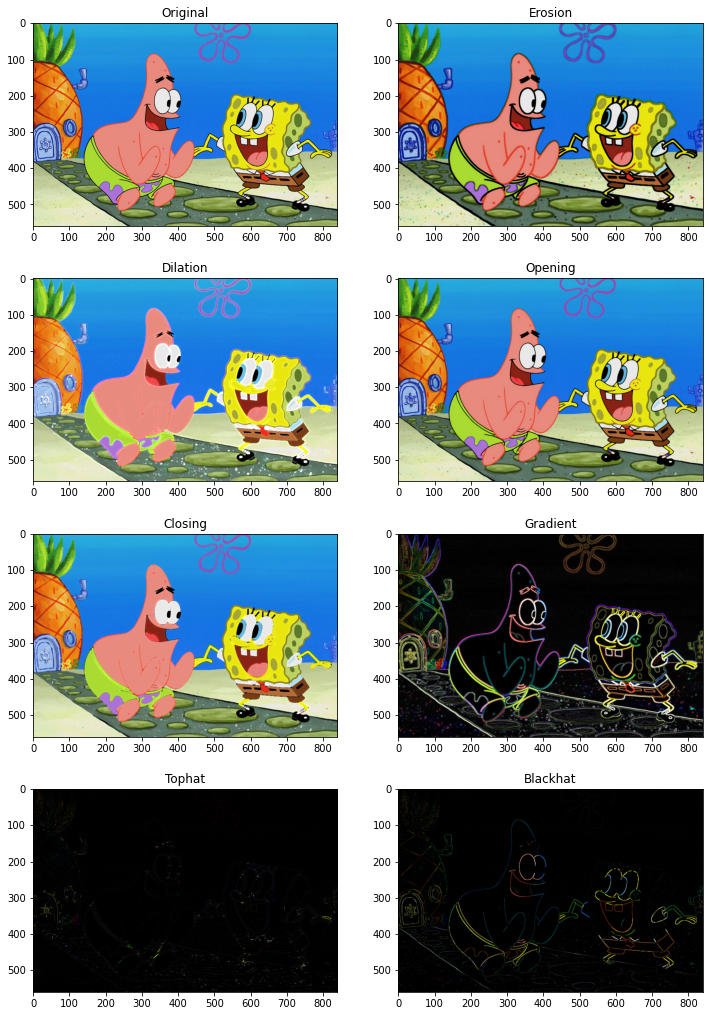

In [6]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('./image/SpongeBob.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

kernel = np.ones((3, 3), np.uint8)  # 卷積核

erosion = cv2.erode(img, kernel, iterations=1)  # 腐蝕
dilation = cv2.dilate(img, kernel, iterations=1)  # 膨脹
opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)  # 開運算
closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)  # 閉運算
gradient = cv2.morphologyEx(img, cv2.MORPH_GRADIENT, kernel)  # 形態學梯度
tophat = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, kernel)  # 禮帽
blackhat = cv2.morphologyEx(img, cv2.MORPH_BLACKHAT, kernel)  # 黑帽

plt.figure(figsize=(12, 18))
plt.subplot(421), plt.imshow(img), plt.title('Original')
plt.subplot(422), plt.imshow(erosion), plt.title('Erosion')
plt.subplot(423), plt.imshow(dilation), plt.title('Dilation')
plt.subplot(424), plt.imshow(opening), plt.title('Opening')
plt.subplot(425), plt.imshow(closing), plt.title('Closing')
plt.subplot(426), plt.imshow(gradient), plt.title('Gradient')
plt.subplot(427), plt.imshow(tophat), plt.title('Tophat')
plt.subplot(428), plt.imshow(blackhat), plt.title('Blackhat')

plt.show()

### Summary : 
| 中文名    | 英文名 | api | 原理 | 個人理解 |
|:--------:|:------:|:---:|:----:|--------:|
|  侵蝕    | erode             | erosion = cv2.erode(src=girl_pic, kernel=kernel) | 在窗中，只要含有０，則窗內全變為０，可以去淺色噪點	| 淺色成分被侵蝕 |
|  膨脹    | dilate            | dilation = cv2.dilate(src=girl_pic, kernel=kernel) | 在窗中，只要含有１，則窗內全變為１，可以增加淺色成分 | 淺色成分得膨脹 |
| 開運算   | morphology-open   | opening = cv2.morphologyEx(girl_pic, cv2.MORPH_OPEN, kernel) | 先侵蝕，後膨脹，去白噪點 | 先合再開，對淺色成分不利 |
| 閉運算   | morphology-close  | closing = cv2.morphologyEx(girl_pic, cv2.MORPH_CLOSE, kernel) | 先膨脹，後侵蝕，去黑噪點 | 先開再合，淺色成分得勢 |
|形態學梯度|morphology-grandient|gradient = cv2.morphologyEx(girl_pic, cv2.MORPH_GRADIENT, kernel)|一幅影像侵蝕與膨脹的區別，可以得到輪廓|數值上解釋為：膨脹減去侵蝕|
| 禮帽     | tophat             |	tophat = cv2.morphologyEx(girl_pic, cv2.MORPH_TOPHAT, kernel) |	原影像減去開運算的差 | 數值上解釋為：原影像減去開運算 |
| 黑帽     | blackhat           | blackhat = cv2.morphologyEx(girl_pic, cv2.MORPH_BLACKHAT, kernel) | 閉運算減去原影像的差 | 數值上解釋為：閉運算減去原影像 |

---

# Module 10. 圖像金字塔

## 10-1: 圖像金字塔理論
> 影像金字塔是影像`多尺度`表達的一種，是一種以多解析度來解釋影像的有效但概念簡單的結構。一幅影像的金字塔是一系列以金字塔形狀排列的解析度`逐步降低`，且來源於同一張原始圖的影像集合。其通過梯次向下取樣獲得，直到達到某個終止條件才停止取樣。我們將一層一層的影像比喻成金字塔，層級越高，則影像越小，解析度越低。將參加融合的的每幅影像分解為多尺度的金字塔影像序列，將低解析度的影像在上層，高解析度的影像在下層，`上層影像的大小為前一層影像大小的 1/4`

> 我們經常會將某種尺寸的圖像轉換為其他尺寸的圖像，如果放大或者縮小圖片的尺寸，籠統來說的話，可以使用 OpenCV 為我們提供的如下兩種方式：
 
> * resize 函數。這是最直接的方式，
> * pyramid 圖像金字塔 
>> * `高斯金字塔 (Gaussianpyramid)` : 用來向下採樣，主要的圖像金字塔
>> * `拉普拉斯金字塔 (Laplacianpyramid)` : 用來從金字塔低層圖像`重建上層`未採樣圖像，在數位影像處理中也即是預測殘差，可以對圖像進行`最大程度的還原`，配合高斯金字塔一起使用。<br>

> 兩者的簡要區別：高斯金字塔用來向下降採樣圖像，而拉普拉斯金字塔則用來從金字塔底層圖像中向上採樣重建一個圖像。

### 高斯金字塔
>`pyrUp( )、pyrDown( )` 函數。即圖像金字塔相關的兩個函數，對圖像進行向上採樣，向下採樣的操作。
 
>  高斯金字塔的生成原理：
> 1. 輸入圖片
> 2. 對圖像進行高斯內核卷積
>> $ Gx = \begin{pmatrix} 1&4&6&4&1\\4&16&24&16&4\\6&24&36&24&6\\4&16&24&16&4\\1&4&6&4&1\end{pmatrix}$
> 3. `將所有偶數行和列去除`，得到 1. 中圖片的1/4大小
> 4. 將 3. 中得到的圖片重複 2. 和 3. 步驟，直到得到 n 級圖像金字塔

><img src=".\image\pyramid.png"  style='height:250px; width:400px'></img>

## 10-2: 高斯金字塔 PyrDown 及 PyrUp
> $pyrDown (src, dst=None, dstsize=None, borderType=None)$

> 注意：dstsize 參數是有默認值的，調用函數的時候``不指定第三個參數``，那麼這個值是按照<br>
>> $Size((src.cols+1) / 2, (src.rows+1) / 2)$<br>

> 計算的。而且不管如何指定這個參數，一定必須保證滿足以下關係式：
>>$| dstsize.width * 2 – src.cols | ≤ 2; | dstsize.height * 2 – src.rows | ≤ 2$

> 也就是說降取樣的意思其實是把影像的尺寸縮減一半，行和列同時縮減一半。

### pyrDown

In [46]:
import cv2
o = cv2.imread('./image/lenaColor.png')

r1 = cv2.pyrDown(o, dstsize=(int(o.shape[1]/2), int(o.shape[0]/2)))
# r1=cv2.pyrDown(o)
r2 = cv2.pyrDown(r1)
r3 = cv2.pyrDown(r2)

print(f'o.shape\t\t: {o.shape}\n'
      f'r1.shape\t: {r1.shape}\n'
      f'r2.shape\t: {r2.shape}\n'
      f'r3.shape\t: {r3.shape}')

cv2.imshow('original', o)
cv2.imshow('r1', r1)
cv2.imshow('r2', r2)
cv2.imshow('r3', r3)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

o.shape		: (512, 512, 3)
r1.shape	: (256, 256, 3)
r2.shape	: (128, 128, 3)
r3.shape	: (64, 64, 3)


-1

### pyrUp

In [47]:
import cv2
# o = cv2.imread('./image/box.png')
o = r3.copy()
r1 = cv2.pyrUp(o)
r2 = cv2.pyrUp(r1)
r3 = cv2.pyrUp(r2)

print(f'o.shape\t\t: {o.shape}\n'
      f'r1.shape\t: {r1.shape}\n'
      f'r2.shape\t: {r2.shape}\n'
      f'r3.shape\t: {r3.shape}')

cv2.imshow('original', o)
cv2.imshow('r1', r1)
cv2.imshow('r2', r2)
cv2.imshow('r3', r3)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

o.shape		: (64, 64, 3)
r1.shape	: (128, 128, 3)
r2.shape	: (256, 256, 3)
r3.shape	: (512, 512, 3)


-1

## 10-3: 實作圖像金字塔

### 取樣可逆性 (down → up) - original

In [48]:
import cv2
o = cv2.imread('./image/lenaColor.png')

down = cv2.pyrDown(o)  # row/2, column/2
up = cv2.pyrUp(down)   # row*2, column*2

diff = up-o 
# diff = o-up 

print(f'o.shape\t\t: {o.shape}\n'
      f'down_up.shape\t: {up.shape}\n'
      f'diff.shape\t: {diff.shape}')

cv2.imshow('original', o)
cv2.imshow('up', up)
cv2.imshow('diff', diff)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

o.shape		: (512, 512, 3)
down_up.shape	: (512, 512, 3)
diff.shape	: (512, 512, 3)


-1

### (up → down) - original

In [50]:
import cv2
o = cv2.imread('./image/lenaColor.png')

up=cv2.pyrUp(o)  # row*2, column*2
down=cv2.pyrDown(up)   # row/2, column/2

diff = down-o 
# diff = o-down 

print(f'o.shape\t\t: {o.shape}\n'
      f'down_up.shape\t: {up.shape}\n'
      f'diff.shape\t: {diff.shape}')

cv2.imshow('original', o)
cv2.imshow('down', down)
cv2.imshow('diff', diff)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

o.shape		: (512, 512, 3)
down_up.shape	: (1024, 1024, 3)
diff.shape	: (512, 512, 3)


-1

### 拉普拉斯金字塔
高斯差分金字塔的構建使用``組和層的結構構建``了一個具有線性關係的金字塔（尺度空間），這樣可以在連續的高斯核尺度上查找圖像的特徵點；另外，它使用一階的高斯差分來近似高斯的拉普拉斯核，大大的減少了運算量。<br>

><img src=".\image\laplacian_pyramid01.jpg"  style='height:50px; width:350px'></img>
><img src=".\image\laplacian_pyramid02.jpg"  style='height:50px; width:350px'></img>

也就是說，拉普拉斯金字塔是通過源圖像減去先縮小後再放大的圖像的一系列圖像構成的。

><img src=".\image\laplacian-pyramid.png"  style='height:300px; width:400px'></img>

In [51]:
import cv2
import numpy as np
G0 = cv2.imread('./image/lenaColor.png')

# go down
G1 = cv2.pyrDown(G0)  # 256*256
G2 = cv2.pyrDown(G1)
G3 = cv2.pyrDown(G2)

# laplacian
L0 = G0 - cv2.pyrUp(G1)# 512*512
L1 = G1 - cv2.pyrUp(G2)
L2 = G2 - cv2.pyrUp(G3)

# go up 
G00 = L0 + cv2.pyrUp(G1)
G11 = L1 + cv2.pyrUp(G2)
G22 = L2 + cv2.pyrUp(G3)

print(f'L0.shape{L0.shape}\n'
      f'L1.shape {L1.shape}\n'
      f'L2.shape {L2.shape}\n'
      f'G0-G00 =  {np.sum(abs(G0-G00))}')

cv2.imshow('G0', G0)
cv2.imshow('G1', G1)
cv2.imshow('G2', G2)

cv2.imshow('L0', L0)
cv2.imshow('L1', L1)
cv2.imshow('L2', L2)

cv2.imshow('G00', G00)
cv2.imshow('G11', G11)
cv2.imshow('G22', G22)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

L0.shape(512, 512, 3)
L1.shape (256, 256, 3)
L2.shape (128, 128, 3)
G0-G00 =  0


-1

---

# Module 11. 影像模板匹配

## 11-1: 什麼是影像模板匹配
> 模板匹配是一種最原始、最基本、最常用的模式識別方法，研究某一特定物件物的圖案位於圖像的什麼地方，進而識別物件物，這就是一個匹配問題。

> 模板就是一副已知的小圖像，而模板匹配就是在一副大圖像中搜尋目標，已知該圖中有要找的目標，且該目標同模板`有相同的尺寸、方向和圖像元素`，通過一定的演算法可以在圖中找到目標，確定其座標位置。

><img src=".\image\match.png"  style='height:200px; width:400px'></img>

> 這就是說，我們要找的模板是圖像裡`標標準準存在的`，這裡說的標標準準，就是說，一旦圖像或者模板發生變化，比如旋轉，修改某幾個圖元，圖像翻轉等操作之後，我們就無法進行匹配了，這也是這個演算法的弊端。所以這種匹配演算法，相當於`人工智障式`匹配，就是在待檢測圖像上，從左到右，從上向下對模板圖像與小東西的圖像進行比對。

>模板匹配，是一種在給定的目標影像中尋找給定的模板影像的技術，原理很簡單，就是利用一些計算相似度的公式來判斷兩張影像之間有多相似

><img src=".\image\lenaMatch.jpg"  style='height:300px; width:300px'></img>

## 11-2: 影像模板匹配介紹  

> 模板影像小於目標影像的話，就需要用 sliding window 的方式來得到多個匹配的結果，可以選擇取最佳匹配或是設定一個門檻值，只要比這個門檻值好的結果都認為是有效的匹配<br>
                                                                                             
>### 距離 distance / 相似度 similarity  (距離越小相似度越高)
>><img src=".\image\distance.jpg"  style='height:500px; width:600px'></img>
>><img src=".\image\vector.png"  style='height:300px; width:400px'></img>

### Euclidean

In [ ]:
import numpy as np
# two points
a = np.array((2, 3, 6, 9, 5))
b = np.array((5, 7, 1, 2, 2))
# distance b/w a and b
d = np.linalg.norm(a-b)
# display the result
d

> * Square difference 平方差, 這是最常見的數學公式

> * Correlation 相關性 : 計算 dot product (內積)，可以想成是計算兩個向量在空間中的距離有多近，就是用 cosine 去算夾角，cosine `值越大代表夾角越小`，代表越接近 ( 假設模板影像是 10*10 的影像，可以被看作是 100 維的向量，每一維是像素的值 )<br>

>><img src=".\image\Dot-Product.jpg"  style='height:200px; width:600px'></img>

>> a dot b 越大, $cos \theta$ 夾角越小

>><img src=".\image\cosine.png"  style='height:200px; width:400px'></img>

>> Correlation coefficient 與 Correlation 差別只在於計算內積時還要減去各個向量的平均值，如此一來相關性就會被放大

### Cosine/Distance

In [2]:
from scipy.spatial import distance
from sklearn.metrics.pairwise import cosine_similarity
a00 = distance.cosine([1, 0], [1, 0])
a45 = distance.cosine([1, 0], [1, 1])
a90 = distance.cosine([1, 0], [0, 1])
a135 = distance.cosine([1, 0], [-1, 1])
a180 = distance.cosine([1, 0], [-1, 0])
a225 = distance.cosine([1, 0], [-1, -1])
a270 = distance.cosine([1, 0], [0, -1])
a315 = distance.cosine([1, 0], [1, -1])
# e = distance.cosine([1, 0, 0], [0, 0, 1])     # 角度概念 3 elements
# f = distance.cosine([100, 0, 0], [0, 1, 0])
# g = distance.cosine([1, 1, 0, 0], [0, 1, 0, 5]) # 4 elements
print(f'a00 =\t{a00:.2f}\n'
      f'a45 =\t{a45:.2f}\n'
      f'a90 =\t{a90:.2f}\n'
      f'a135 =\t{a135:.2f}\n'
      f'a180 =\t{a180:.2f}\n'
      f'a225 =\t{a225:.2f}\n'
      f'a270 =\t{a270:.2f}\n'
      f'a315 =\t{a315:.2f}\n'
      f'{cosine_similarity([[1,0,0]], [[0,0,1]])}')  # similarity is opposite with distance

a00 =	0.00
a45 =	0.29
a90 =	1.00
a135 =	1.71
a180 =	2.00
a225 =	1.71
a270 =	1.00
a315 =	0.29
[[0.]]


### hamming

In [3]:
from scipy.spatial import distance
a=distance.hamming([1, 0, 0], [0, 1, 0])
b=distance.hamming([1, 0, 0], [1, 0, 0])
c=distance.hamming([1, 0, 0], [2, 0, 0])
d=distance.hamming([1, 0, 0], [3, 0, 0])
a,b,c,d

(0.6666666666666666, 0.0, 0.3333333333333333, 0.3333333333333333)

## 11-3: 實作影像模板匹配
|說明        |語法 method  | 代碼  |值  |
|:-------------|:---------------|:-:|---|
|平方差匹配     |TM_SQDIFF        |1 |minVal|
|標準平方差匹配 |TM_SQDIFF_NORMED |2 |minVal|
|相關匹配       |TM_CCORR         |3 |maxVal|
|標準相關匹配   |TM_CCORR_NORMED  |4 |maxVal|
|相關匹配       |TM_CCOEFF        |5 |maxVal|
|標準相關匹配   |TM_CCOEFF_NORMED |6 |-1 ~ 1 (maxVal)|

> ### TM_SQDIFF 平方差匹配 : `minVal`

>> 從名字來理解，平方差匹配就是通過計算每個圖元點的`差的平方的和`，和數學中統計裡面的`平方差類似`。但是因為我們要的只是一個值，所以我們最後不需要求平均。<br>

>> $R(x,y)= \sum _{x',y'} (T(x',y')-I(x+x',y+y'))^2$

> ### TM_SQDIFF_NORMED 標準平方差匹配 : `minVal`
>> 這個只是對上面的進行了標準化處理，經過處理後，上面的值`就不會太大`<br>

>>$R(x,y)= \frac{\sum_{x',y'} (T(x',y')-I(x+x',y+y'))^2}{\sqrt{\sum_{x',y'}T(x',y')^2 \cdot \sum_{x',y'} I(x+x',y+y')^2}}$

0.0


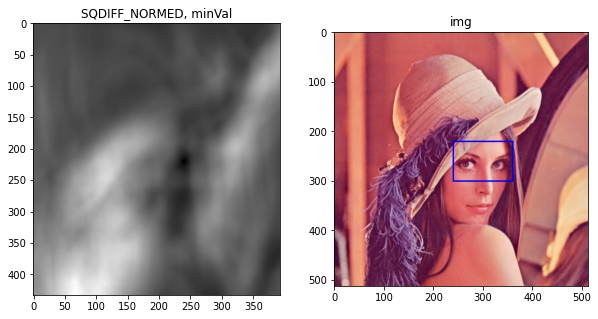

-1

In [4]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# methods=[cv.TM_SQDIFF_NORMED,cv.TM_CCORR_NORMED,cv.TM_CCOEFF_NORMED]

img=cv2.imread('./image/lenaColor.png')
template = img[220:300, 240:360]   # 模板
# template = img[320:400, 250:300]
cv2.imshow('template', template)

th, tw, _ = template.shape[::]    # 模板大小
rv = cv2.matchTemplate(img, template, cv2.TM_SQDIFF_NORMED)

minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(rv)

topLeft = minLoc
bottomRight = (topLeft[0]+tw, topLeft[1]+th)

cv2.rectangle(img, topLeft, bottomRight, 255, 2)
print(minVal)
fig=plt.figure(figsize=(10, 5))

plt.subplot(121);  plt.imshow(rv, cmap='gray');  plt.title('SQDIFF_NORMED, minVal')
plt.subplot(122);  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), cmap='gray');  plt.title('img')
plt.show()

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

> ### TM_CCORR 相關匹配 : `maxVal`
>> 這類方法採用範本和圖像間的乘法操作, 所以``較大的數表示匹配程度較高``, 0標識最壞的匹配效果。<br>

>> $R(x,y)= \sum _{x',y'} (T(x',y') \cdot I(x+x',y+y'))$
> ### TM_CCORR_NORMED 標準相關匹配 : `maxVal`
>> 這個只是對上面的進行了標準化處理，經過處理後，上面的`值就不會太大`。<br>

>> $R(x,y)= \frac{\sum_{x',y'} (T(x',y') \cdot I(x+x',y+y'))}{\sqrt{\sum_{x',y'}T(x',y')^2 \cdot \sum_{x',y'} I(x+x',y+y')^2}}$

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# methods=[cv.TM_SQDIFF_NORMED,cv.TM_CCORR_NORMED,cv.TM_CCOEFF_NORMED]

img=cv2.imread('./image/lenaColor.png', 1)
template = img[220:300, 240:360]
# template = img[320:400, 250:300]
cv2.imshow('template',template)

th, tw, _ = template.shape[::]
rv = cv2.matchTemplate(img, template, cv2.TM_CCORR_NORMED)

minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(rv)
topLeft = maxLoc
bottomRight = (topLeft[0]+tw, topLeft[1]+th)

cv2.rectangle(img, topLeft, bottomRight, 255, 2)

fig=plt.figure(figsize=(10, 5))

plt.subplot(121), plt.imshow(rv, cmap='gray');  plt.title('CCORR_NORMED, MaxVal')
plt.subplot(122), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), cmap='gray')
plt.show()

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

### TM_CCOEFF 相關匹配 : maxVal
> 這類方法將模版對其均值的相對值與圖像對其均值的相關值進行匹配, 越大越相似<br>
>>$R(x,y)= \sum _{x',y'} (T'(x',y') \cdot I'(x+x',y+y'))$<br>

>> where<br>

>>$\begin{array}{l} T'(x',y')=T(x',y') - 1/(w \cdot h) \cdot \sum 
_{x'',y''} T(x'',y'') \\ I'(x+x',y+y')=I(x+x',y+y') - 1/(w \cdot h) 
\cdot \sum _{x'',y''} I(x+x'',y+y'') \end{array}$

### cv2.TM_CCOEFF_NORMED 標準相關匹配 : maxVal
> 這個只是對上面的進行了標準化處理，經過處理後，上面的值就不會太大。
> 計算出的相關係數被限制`在了 -1 到 1 之間`
> * 1 表示完全相同
> * -1 表示亮度正好相反
> * 0 表示没有線性相關隨機序列

>> $R(x,y)= \frac{ \sum_{x',y'} (T'(x',y') \cdot I'(x+x',y+y')) }{ \sqrt{\sum_{x',y'}T'(x',y')^2 \cdot \sum_{x',y'} I'(x+x',y+y')^2} }$<br>

>> where <br>

>> $\begin{array}{l} T'(x',y')=T(x',y') - 1/(w \cdot h) \cdot \sum 
_{x'',y''} T(x'',y'') \\ I'(x+x',y+y')=I(x+x',y+y') - 1/(w \cdot h) 
\cdot \sum _{x'',y''} I(x+x'',y+y'') \end{array}$

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# methods=[cv.TM_SQDIFF_NORMED,cv.TM_CCORR_NORMED,cv.TM_CCOEFF_NORMED]

img=cv2.imread('./image/lenaColor.png', 1)
template = img[220:300, 240:360]
# template = img[320:400, 250:300]
cv2.imshow('template',template)
th, tw, _ = template.shape[::]
rv=cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED)

minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(rv)
topLeft = maxLoc                                   # 只拿 max 來用
bottomRight = (topLeft[0]+tw, topLeft[1]+th)

cv2.rectangle(img, topLeft, bottomRight, 255, 2)

fig=plt.figure(figsize=(10, 5))

plt.subplot(121), plt.imshow(rv, cmap='gray');  plt.title('CCOEFF, MaxVal')
plt.subplot(122), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), cmap='gray')
plt.show()

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)

### use np.where

In [ ]:
import numpy as np
a=np.array([[3,6,8,1,2,88],
            [6,3,9,14,6,22]])  # return index

b=np.where(a>5, 1, -1)
a, b

### 多對向的模板匹配
### use np.where

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# methods=[cv.TM_SQDIFF_NORMED,cv.TM_CCORR_NORMED,cv.TM_CCOEFF_NORMED]

img=cv2.imread('./image/lenaColor4.jpg', 1)
template = img[200:250, 200:300]
# template = img[320:400, 250:300]
cv2.imshow('template', template)    

th, tw, _ = template.shape[::]
rv = cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED)   # 在 -1 到 1 之間
# print(rv)
#----- threshold -------
threshold = .8   # try 0.95
loc=np.where(rv >= threshold)        # 大於 threshold 的 index 都撈出來
print(f'numbers of match rectangle : {len(loc[0])}\n')

for pt in zip(*loc[::]):
    print(f'match rectangle top_left : {pt}')
    cv2.rectangle(img, pt, (pt[0]+tw, pt[1]+th), 255, 1)
    
plt.figure(figsize = (8, 8))    
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

In [8]:
import cv2
import numpy as np
# from matplotlib import pyplot as plt

img_rgb = cv2.imread('./image/mario.jpg')
# img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
template = cv2.imread('./image/marioCoin.jpg', 1)
template.shape

h, w, _ = template.shape[::]

res = cv2.matchTemplate(img_rgb, template, cv2.TM_CCOEFF_NORMED)    # 在了 -1 到 1 之間
# print(res)
threshold = .8                              # 準確度越高背景會影響，找到的數量會越少
loc = np.where(res >= threshold)
print(f'numbers of match rectangle : {len(loc[0])}\n')

for idx, pt in enumerate(zip(*loc[::-1])):
#     print(f'match rectangle top_left : {pt}')
    cv2.rectangle(img_rgb, pt, (pt[0]+w, pt[1]+h), (0, 255, 255), 2)
    
# cv2.imwrite('res.png',img_rgb)
cv2.imshow('mario coin', template)
cv2.imshow('result', img_rgb)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

numbers of match rectangle : 841



-1

---

# Module 12. 特徵擷取(SIFT)

## 12-1: 擷取原理

> * 要辨識某物體的條件就是先掌握其特徵！由於我們要辨識的是某個物件而非整張相片，因此需要提取所謂稱為「Local features」的特徵，作法是先在影像中`選取重要的特徵點`，接著以其為 base 取得周圍的特徵（即local features），這些來自不同相片的 local features 會透過稍後會說明的 Feature matching 功能來比對是否有相同的物件。

> * 特徵點 → 局部特徵 → Feature matching 這些特性可用 `edges、corners、blobs (斑點)` 等組合來描述 Keypoint detection、Feature extraction 以及 Feature matching

>> * Keypoint detection ：在圖片中取得感興趣的關鍵點（可能為 edges、corners 或 blobs）。
>> * Feature extraction ：針對各關鍵點提取該區域的 features（我們稱為 local features）。
>> * 關鍵點篩選並進行 Feature matching。

>> https://gilscvblog.com/2013/08/18/a-short-introduction-to-descriptors/

## 12-2: Keypoint Descriptor
### FAST – FastFeatureDetector
> 原理簡單, 執行速度相當快, 主要用於偵測 corners，亦可偵測 blob。適用於要求速度的 real-time analysis, 適用於`速度慢或較低階的執行環境`。使用度極高，尤其在需要即時的 realtime 環境。

> * FAST 方法認為，一個以 p 為中心、半徑為 r 的圓形，若它位於一個所謂的 corner上，那麼該圓的圓周上必有連續 n 個點，其強度值`大於或小於中心點 p `加上一個指定的 threshold 門檻的強度值。如果是的話，該中心點 p 便被認為是 keypoint。

> * 考慮是否應該將中心像素 p 視為關鍵點。中心像素 p 具有灰度強度值 p ＝ 32。為了使該像素成為關鍵點，必須在圓的邊界上具有 n = 12 / 16 (一般 `3/4`) 個連續像素，`這些像素要不就比 p + t 亮，要不就比 p – t 暗`。在此示例中，假設 t = 16。

><img src=".\image\KpFast01.png"  style='height:300px; width:600px'></img>
><img src=".\image\KpFast03.png"  style='height:300px; width:300px'></img>

> FAST演算法提取角點的步驟：
> * 在圖像中選擇圖元 p，假設其灰度值為：Ip
> * 設置一個閾值 T，例如：Ip 的20%
> * 選擇 p 周圍半徑為 3 的圓上的 16 個圖元，作為比較圖元
> * 假設選取的圓上有`連續`的 N 個圖元`大於Ip+T或者小於 Ip−T`，那麼可以認為圖元 p 就是一個特徵點。（N 通常取12，即為 FAST-12；常用的還有 FAST-9, FAST-11）。

> 缺點 :
> * 檢測到的特徵點過多並且會出現 `紮堆` 的現象。這可以在第一遍檢測完成後，使用非最大值抑制（Non-maximal suppression），在`一定區域內僅保留回應極大值的角點`，避免角點集中的情況。
> * FAST 提取到的角點沒有方向和尺度資訊
> * SIFT 和 SURF 演算法都包含有各自的特徵點描述子的計算方法，而 FAST 不包含特徵點描述子的計算，僅僅只有特徵點的提取方法，這就需要一個特徵點描述方法來描述 FAST 提取到的特徵點，以方便特徵點的匹配

https://docs.opencv.org/3.4/df/d74/classcv_1_1FastFeatureDetector.html

## FAST

In [9]:
# from __future__ import print_function
import numpy as np
import cv2
  
# load the image and convert it to grayscale
# image = cv2.imread('./image/lenaColor.png')
image = cv2.imread('./image/fruits.png')

orig = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  
detector = cv2.FastFeatureDetector_create(threshold=None, nonmaxSuppression=None)        # Fast feature detector
kps = detector.detect(gray, None)

print(f'# of keypoints : {len(kps)}\n{type(kps)}\n{kps[:10]}')

# for kp in kps:
#     r = int(0.5 * kp.size)
#     (x, y) = np.int0(kp.pt)
#     cv2.circle(image, (x, y), r, (0, 255, 255), 2)
image = cv2.drawKeypoints(gray, kps, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)   # image : image output

# show the image
cv2.imshow('Images', np.hstack([orig, image]))
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

# of keypoints : 1080
<class 'tuple'>
(<KeyPoint 000001542FC017B0>, <KeyPoint 000001542FC018A0>, <KeyPoint 000001542FC01690>, <KeyPoint 000001542FC01810>, <KeyPoint 000001542FC01630>, <KeyPoint 000001542FC01AB0>, <KeyPoint 000001540178A330>, <KeyPoint 000001540178A4B0>, <KeyPoint 000001540178A480>, <KeyPoint 000001540178A3F0>)


-1

### SIFT : Scale Invariant Feature Transform，尺度不變特徵變換。
> SIFT特徵對`旋轉、尺度縮放、亮度變化等保持不變性`，是一種非常穩定的局部特徵。

> Fast Keypoint 在影像旋轉的情況下也可以檢測到，但是如果減小(或者增加)影像的大小，可能會丟失影像的某些部分，甚至導致檢測到的角點發生改變。這樣的損失現像`需要一種與影像比例無關`的角點檢測方法來解決。尺度不變特徵變換 (Scale-Invariant Feature Transform, SIFT) 可以解決這個問題。

> SIFT 演算法利用 DoG (差分高斯)來提取關鍵點(或者說成特徵點)，DoG 的思維是用不同的尺度空間因子 (高斯正態分佈的標準差σ) 對影像進行平滑，然後比較平滑後圖像的區別，差別大的畫素就是特徵明顯的點，即可能是特徵點。對得到的所有特徵點，我們剔除一些不好的，SIFT運算元會把剩下的每個特徵點用一個128維的特徵向量進行描述

> * 原理較為複雜。
> * 主要針對 blob 偵測，不過亦可偵測 corners。
> * 可適應物件的 scale (大小變化)及 angle（旋轉角度）等情況。
> * 在DoG模型中，使用了`不同尺寸影像並套用高斯模糊`，`比較不同模糊比例之間的變化`，來決定是否為 keypoint。
> * 由於計算量大，DoG 的執行速度較慢，不適用於 realtime 的環境。
> * SIFT已廣泛的應用於電腦視覺領域，並成為評定新 keypoint detecter 的效率指標。

> 速度上 ORB > SURF > SIFT，SURF的魯鈍性(抗干擾能力）更好一些。

><img src=".\image\sift_dog.jpg"  style='height:350px; width:800px'></img>
><img src=".\image\SIFT.png"  style='height:350px; width:800px'></img>
https://aishack.in/tutorials/sift-scale-invariant-feature-transform-scale-space/

> ### SIFT 演算法: 
> 1. 準備輸入圖像的不同比例的副本。為每個比例創建八度比例圖像。
> 2. 對於每個八度比例，高斯模糊濾鏡會應用到所有強度增加的圖像。
> 3. 對八度內的所有兩個後續圖像計算高斯差（DoG）。
> 4. 掃描中間DoG相對於 26 鄰域的極值。通過在極值上應用高通濾波器來檢索特徵。
> 5. 確定特徵的`漸變，方向和位置`。

## SIFT

In [ ]:
import numpy as np
import cv2
gray = cv2.imread('./image/lenaColor.png', 0)
sift=cv2.xfeatures2d.SIFT_create()    # create object
# sift = cv2.SIFT_create()
kp = sift.detect(gray, None)
print(f'kp[:5]\t:\n{kp[:5]}\n\n'
      f'len(kp)\t\t: {len(kp)}\n'
      f'kp[0].pt\t: {kp[0].pt}\n'
      f'kp[0].pt\t: {kp[0].size}')

img = cv2.drawKeypoints(gray, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)   # output to 'img'
# img = cv2.drawKeypoints(gray, kp, None)   # out to 'img'
cv2.imshow('sift_kp', img)

cv2.imwrite('./image/lena_sift_kp.jpg', img)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

### sift / save keypoint

In [ ]:
import numpy as np
import cv2

gray = cv2.imread('.\image\mybaby.jpg', 0)
# img = cv2.imread('./image/lenaColor.png', 0)

sift = cv2.xfeatures2d.SIFT_create()
# kp = sift.detect(gray,None)

# directly find keypoints and descriptors in a single step
kp, des = sift.detectAndCompute(gray, None)   # kp指關鍵點, des指關鍵點的特徵描述
print(len(kp))
img = cv2.drawKeypoints(gray, kp, None)
print(des[0])                                 # add

np.save('.\image\mybaby_sift_kp', des)
cv2.imshow('SIFT', img)
# cv2.waitKey(0)

cv2.imwrite('.\image\mybaby_sift.jpg', img)

cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

### SURF : This algorithm `is patented`
Speeded Up Robust Features。加速版的SIFT。
SURF的流程和 SIFT 比較類似，這些改進體現在以下幾個方面：<br>
 * 特徵點檢測是基於 Hessian 矩陣，依據 Hessian 矩陣行列式的極值來定位特徵點的位置。
 * 並且將 Hession 特徵計算與高斯平滑結合在一起，兩個操作通過近似處理得到一個核範本。
 * 在構建尺度空間時，使用`box filter`與源圖像卷積，而不是使用DoG運算元。
 * SURF 使用一階 Haar 小波在 x、y 兩個方向的回應作為構建特徵向量的分佈資訊。

SURF 演算法比 SIFT 快好幾倍，它吸收了 SIFT 演算法的思想。SURF 採用 Hessian 演算法檢測關鍵點。SURF 需要提供閾值，特徵隨著閾值的增加而減少。

In [ ]:
import numpy as np
import cv2
gray = cv2.imread('./image/lenaColor.png', 0)

surf = cv2.xfeatures2d.SURF_create()
# Find keypoints and descriptors directly
kp, des = surf.detectAndCompute(gray, None)
len(kp)

### Brief
過程如下：

 * 為減少雜訊干擾，先對圖像進行高斯濾波（方差為2，高斯窗口為 9x9）<br>
 * 以特徵點為中心，取 SxS 的鄰域大視窗。在大視窗中隨機選取一對（兩個）5x5 的子視窗，比較子視窗內的圖元和（可用積分圖像完成），進行二進位賦值.（一般 S=31）其中，p(x)，p(y)分別隨機點 x=(u1, v1), y=(u2, v2) 所在 5x5 子視窗的圖元和.<br>
 * 在大視窗中隨機選取N對子視窗，重複步驟2 的二進位賦值，形成一個二進位編碼，這個編碼就是對特徵點的描述，即特徵描述子.（一般 N=256）<br>
非常重要的一點是：BRIEF 是一種特徵描述符，它不提供查找特徵的方法。所以我們不得不使用其他特徵檢測器，比如 SIFT 和 SURF 等。原始文獻推薦使用 CenSurE 特徵檢測器，這種演算法很快。而且 BRIEF 演算法對 CenSurE 關鍵點的描述效果要比 SURF 關鍵點的描述更好。

簡單來說 BRIEF 是一種對特徵點描述符計算和匹配的快速方法。這種演算法可以實現很高的識別率，除非出現平面內的大旋轉。

### brief

In [ ]:
import numpy as np
import cv2 
from matplotlib import pyplot as plt

img = cv2.imread('./image/lenaColor.png',0)
# star = cv2.xfeatures2d.StarDetector_create()
# kp = star.detect(img,None)

brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()  # 初始化BRIEF特徵提取器
kp, des = brief.compute(img, kp)                          # 計算特徵描述
img = cv2.drawKeypoints(img, kp, None, color=-1)

cv2.imshow('Brief', img)

print(f'{brief.descriptorSize()}\n{des.shape}')
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

### star

In [ ]:
import numpy as np
import cv2 
from matplotlib import pyplot as plt

img = cv2.imread('./image/lenaColor.png',0)

star = cv2.xfeatures2d.StarDetector_create()               # 初始化STAR檢測器
kp = star.detect(img,None)                                # 使用STAR尋找特徵點
img = cv2.drawKeypoints(img, kp, None, color=-1)
print(len(kp))
cv2.imshow('Star', img)

cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

### ORB : ORiented Brief / Oriented FAST and Rotated BRIEF
> ORB亦是針對 FAST 的強化，但除了scale space invariance，亦加入了旋轉不變性(rotation invariance)。

> ORB原理有三大步驟：
> * Pyramid 圖像尺寸並進行各尺寸的FAST計算。
> * 使用 Harris keypoint detector的方法計算每個 keypoint分數（是否近似corner？），並進行排序，最多僅取500個keypoints，其餘則丟棄。
> * 於此第三步中加入旋轉不變性，使用「intensity centroid」計算每個 keypoint 的 rotation。ORB 與 BRISK 相同，繼承了 FAST 運算快速的特性，可適用於realtime分析。

ORB 是用來取代 SIFT 和 SURF 的，與兩者相比，ORB有更快的速度。ORB 用FAST來檢測關鍵點，用 BRIEF 來進行關鍵點特徵描述。

In [ ]:
import cv2
import numpy as np
# image = cv2.imread('./image/blox.jpg')
image = cv2.imread('./image/lenaColor.png')
# image = cv2.imread('./image/lenaColor.png', cv2.COLOR_BGR2GRAY)

sift_feature = cv2.xfeatures2d.SIFT_create()
sift_kp = sift_feature.detect(image)
sift_out = cv2.drawKeypoints(image, sift_kp, None)

orb_feature = cv2.ORB_create()
orb_kp  = orb_feature.detect(image)
orb_out  = cv2.drawKeypoints(image, orb_kp, None)

font = cv2.FONT_HERSHEY_SIMPLEX
loc = (10, 40); color = (255, 255, 255)
cv2.putText(image, 'original', loc, font, 1, color, 2, cv2.LINE_AA)
cv2.putText(sift_out, 'sift', loc, font, 1, color, 2, cv2.LINE_AA)
cv2.putText(orb_out, 'orb', loc, font, 1, color, 2, cv2.LINE_AA)

image = cv2.hconcat([image, sift_out, orb_out])

cv2.imshow('image', image)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

### Harris
> 速度相當快，但仍較 FAST 慢，不過偵測 corner 比起 FAST 準確一些。廣泛應用於偵測 edges 及 corners, Harris 可用於識別角點。此函數可以很好的檢測角點，這些角點在圖像旋轉的情況下也能被檢測到。但是如果減少或者增加圖像的尺寸，可能會丟失圖像的某些部分，也有可能增加圖像的角點。

In [ ]:
import numpy as np
import cv2
filename = './image/lenaColor.png'
gray = cv2.imread(filename, 0)
gray = np.float32(gray)

dst = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)  
# blockSize:檢測的臨點數, ksize:sobel邊緣檢測的核, k:目標函式的一個引數（一般取值較小）

#result is dilated for marking the corners, not important
dst = cv2.dilate(dst,None)

# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.01*dst.max()]=[0,0,255]

cv2.imshow('dst',img)
if cv2.waitKey(0) & 0xff == 27:
    cv2.destroyAllWindows()
    cv2.waitKey(1)    

## 12-3: Keypoint Matching

### match knn
> BFmatcher (暴力匹配)：計算匹配圖層的一個特徵描述子與待匹配圖層的所有特徵描述子的距離返回最近距離。<br>
> FlannBasedMatcher：是目前最快的特徵匹配演算法（最近鄰搜尋）

那麼這個這個DMatch資料結構究竟是什麼呢？<br>
它包含三個非常重要的資料分別是 queryIdx，trainIdx，distance
* queryIdx：測試圖像的特徵點描述符的下標（第幾個特徵點描述符），同時也是描述符對應特徵點的下標。
* trainIdx：樣本圖像的特徵點描述符下標,同時也是描述符對應特徵點的下標。
* distance：代表這怡翠匹配的特徵點描述符的歐式距離，數值越小也就說明倆個特徵點越相近。

In [ ]:
import cv2

# ======== example 0 =================
# img1 = cv2.imread('./image/box.png')
# img2 = cv2.imread('./image/box_in_scene.png')

# ======== example 1 =================
# img1 = cv2.imread('./image/testpic.jpg')
# img2 = cv2.imread('./image/testpic2.jpg')

# ======== example 2 =================
img1 = cv2.imread('./image/aiotbooks.jpg')
img2 = cv2.imread('./image/aiotimage.jpg')

# ======== example 3 =================
# img1 = cv2.imread('./image/mario.jpg')
# img2 = cv2.imread('./image/marioCoin.jpg')

feature = cv2.xfeatures2d.SIFT_create()
# feature = cv2.xfeatures2d.SURF_create()   # This algorithm is patented and is excluded in this configuration

kp1, des1 = feature.detectAndCompute(img1, None)
kp2, des2 = feature.detectAndCompute(img2, None)

# ========= BFMatcher ================
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)  # k Count of best matches found per each query descriptor
# matches = bf.Match(des1, des2)  # k Count of best matches found per each query descriptor
# matches = sorted(matches, key = lambda x:x.distance)

print(f'len(matches)\t\t= {len(matches)} 組, \tk = 2\n')

for i in range(2) :
    for j in range(2) :
        print(f'matches[{i}]\t\t= {matches[j]}\n'
              f'matches[{i}][{j}].queryIdx\t= {matches[i][j].queryIdx}\n'
              f'matches[{i}][{j}].trainIdx\t= {matches[i][j].trainIdx}\n'
              f'matches[{i}][{j}].distance\t= {matches[i][j].distance}\n')
    print('-'*80)

good = []
for m, n in matches:
    if m.distance < .4 * n.distance:      # #如果第一個鄰近距離比第二個鄰近距離的0.4倍小，則保留 try 0.5, 0.6, 0.7
#     if m.distance / n.distance < 0.4:      # #如果第一個鄰近距離比第二個鄰近距離的0.4倍小，則保留 try 0.5, 0.6, 0.7
#     if m.distance < 100:      # #如果第一個鄰近距離
        good.append(m)
print(f'Matching points : {len(good)}')
img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, [good], outImg=None, 
        flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

img3 = cv2.resize(img3, (960, 460))
cv2.imshow('video', img3)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

### orb match

In [ ]:
import cv2

# ======== example 0 =================
# img1 = cv2.imread('./image/box.png')
# img2 = cv2.imread('./image/box_in_scene.png')

# ======== example 1 =================
# img1 = cv2.imread('./image/testpic.jpg')
# img2 = cv2.imread('./image/testpic2.jpg')

# ======== example 2 =================
img1 = cv2.imread('./image/aiotbooks01.jpg')
img2 = cv2.imread('./image/aiotimage.jpg')

# ======== example 3 =================
# img1 = cv2.imread('./image/mario.jpg')
# img2 = cv2.imread('./image/marioCoin.jpg')

orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1,des2)

matches = sorted(matches, key=lambda x:x.distance)
img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches[:30], outImg=None,
                       flags = cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

# width, height, channel = img3.shape
# ratio = float(width) / float(height)
# img3 = cv2.resize(img3, (1024, int(1024 * ratio)))
cv2.imshow('image', img3)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

### FLANN 是快速最近鄰搜尋包 (Fast_Library_for_Approximate_Nearest_Neighbors) 的簡稱。
> 它是一個對大資料集和高維特徵進行最近鄰搜尋的演算法的集合,而且這些演算法都已經被優化過了。在面對大資料集時它的效果要好於 BFMatcher。

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

img1 = cv2.imread('./image/box.png', 0)  # queryImage
img2 = cv2.imread('./image/box_in_scene.png', 0)  # trainImage

# Initiate SIFT detector
# sift = cv2.SIFT()
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# ============= FLANN parameters ===========
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)  # or pass empty dictionary

# ============= Brute-Force ============
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# ============= Flann ============
# flann = cv2.FlannBasedMatcher(index_params, search_params)
# matches = flann.knnMatch(des1, des2, k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0, 0] for i in range(len(matches))]

# ratio test as per Lowe's paper
for i, (m, n) in enumerate(matches):
    if m.distance < 0.7 * n.distance:
        matchesMask[i] = [1, 0]

draw_params = dict(matchColor=(0, 255, 0),
                   singlePointColor=(255, 0, 0),
                   matchesMask=matchesMask,
                   flags=0)

img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, matches, None, **draw_params)

plt.figure(figsize=(12, 6))
plt.imshow(img3, ), plt.show()

cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

### homography

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

MIN_MATCH_COUNT = 10
# =======================================
# img1 = cv2.imread('./image/box.png', 0)    # Source Image
# img2 = cv2.imread('./image/box_in_scene.png', 0)    # Check Image
#=======================================
img1 = cv2.imread('./image/jp_01.png', 0)    # Source Image
img2 = cv2.imread('./image/jp_02.png', 0)    # Check Image

#=======================================
# img1 = cv2.imread('./image/douglas_01.png', 0)    # Source Image
# img2 = cv2.imread('./image/douglas_02.png', 0)    # Check Image

# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1, des2, k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)
   
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()

    h,w = img1.shape
    pts = np.float32([[0,0],[0,h-1],[w-1,h-1],[w-1,0]]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)

    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

else:
    print(f'Not enough matches are found - {len(good)}/{MIN_MATCH_COUNT}')
    matchesMask = None

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
        singlePointColor = None,
        matchesMask = matchesMask, # draw only inliers
        flags = 2)

img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)

# cv2.imshow('Result', img3)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

plt.figure(figsize=(10, 8))
plt.imshow(img3, 'gray'),plt.show()

---